In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, model_selection, preprocessing, pipeline, impute, feature_selection
from sklearn.experimental import enable_iterative_imputer
from itertools import chain, combinations, product
import math
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

%matplotlib inline
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

import networkx as nx
import graphviz

import random

import researchpy as rp
import scipy.stats as stats

In [2]:
# Constants
EPSILON = 0.001

In [3]:
data = pd.read_csv("insurance.csv")
#data = data.convert_dtypes()
data

GoodStudent         Age    SocioEcon RiskAversion VehicleYear  \
0            False       Adult        Prole  Adventurous       Older   
1            False      Senior        Prole     Cautious     Current   
2            False      Senior  UpperMiddle   Psychopath     Current   
3            False  Adolescent       Middle       Normal       Older   
4            False  Adolescent        Prole       Normal       Older   
...            ...         ...          ...          ...         ...   
19995        False       Adult        Prole  Adventurous       Older   
19996        False       Adult       Middle       Normal       Older   
19997        False      Senior  UpperMiddle       Normal     Current   
19998        False       Adult       Middle       Normal       Older   
19999        False       Adult       Middle       Normal       Older   

      ThisCarDam RuggedAuto  Accident    MakeModel DrivQuality  ... HomeBase  \
0       Moderate   EggShell      Mild      Economy        Poor  ...     City   
1           None   Football      None      Economy      Normal  ...     City   
2           None   Football      None  FamilySedan   Excellent  ...     City   
3           None   EggShell      None      Economy      Normal  ...   Suburb   
4       Moderate   Football  Moderate      Economy        Poor  ...     City   
...          ...        ...       ...          ...         ...  ...      ...   
19995       Mild   Football      Mild      Economy        Poor  ...     City   
19996       None       Tank      None  FamilySedan      Normal  ...   Suburb   
19997       None   Football      None       Luxury   Excellent  ...   Secure   
19998       None   Football      None  FamilySedan   Excellent  ...   Suburb   
19999       None       Tank      None  FamilySedan   Excellent  ...   Secure   

       AntiTheft  PropCost  OtherCarCost OtherCar   MedCost Cushioning Airbag  \
0          False   TenThou      Thousand     True  Thousand       Poor  False   
1           True  Thousand      Thousand     True  Thousand       Good   True   
2          False  Thousand      Thousand    False  Thousand       Good   True   
3          False  Thousand      Thousand     True  Thousand       Fair  False   
4          False   TenThou      Thousand    False  Thousand       Fair  False   
...          ...       ...           ...      ...       ...        ...    ...   
19995      False  Thousand      Thousand     True  Thousand       Fair  False   
19996      False  Thousand      Thousand     True  Thousand       Good  False   
19997       True   TenThou      Thousand    False  Thousand  Excellent   True   
19998      False  Thousand      Thousand     True  Thousand       Good   True   
19999      False  Thousand      Thousand     True  Thousand  Excellent   True   

        ILiCost DrivHist  
0      Thousand     Many  
1      Thousand     Zero  
2      Thousand      One  
3      Thousand     Zero  
4      Thousand     Many  
...         ...      ...  
19995  Thousand     Many  
19996  Thousand     Zero  
19997  Thousand     Zero  
19998  Thousand     Zero  
19999  Thousand     Zero  

[20000 rows x 27 columns]

In [4]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = data[data.columns.drop("Accident")]
y = data["Accident"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [5]:
app = X_train.copy()
app["Accident"] = y_train

learner=gum.BNLearner(app)

bn = learner.learnBN()

bn=learner.useGreedyHillClimbing().useScoreK2().learnBN()


In [6]:
gnb.flow.add(gnb.getBN(bn,size="20"))
gnb.flow.display()

In [7]:
acc = 0
domain = sorted(np.unique(y_train.to_numpy()))
for i in X_test.index :
    ie=gum.LazyPropagation(bn)
    ie.addTarget("Accident")
    instance = X_test.loc[i]
    for j in X_test.columns :
        ie.addEvidence(j,str(instance[j]))
    ie.makeInference()
    post = ie.posterior("Accident")
    #print(post)
    #print(y_test.loc[i])
    acc = acc + post[domain.index(y_test.loc[i])]
print(acc / len(X_test.index))

0.9237731239607289


In [8]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))

True

In [9]:
bn.nodeset(["OtherCarCost"])

<Swig Object of type 'gum::NodeSet *' at 0x7f1dd9b2cfc0>

In [10]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.setEvidence({"RiskAversion" : "Psychopath", "Accident" : "None"})
ie.evidenceProbability()
#print(ie.posterior(bn.idFromName("Accident")))


0.007333603681092642

In [11]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.addJointTarget(set(["Accident", "RiskAversion"]))
#ie.setEvidence({"RiskAversion" : "Psychopath"})
#ie.evidenceProbability()
print(ie.jointPosterior(set(["Accident", "RiskAversion"])))


      ||  RiskAversion                         |
Accide||Adventuro|Cautious |Normal   |Psychopat|
------||---------|---------|---------|---------|
Mild  || 0.0312  | 0.0154  | 0.0400  | 0.0019  |
Modera|| 0.0280  | 0.0128  | 0.0342  | 0.0017  |
None  || 0.1594  | 0.1915  | 0.3598  | 0.0073  |
Severe|| 0.0440  | 0.0189  | 0.0512  | 0.0027  |



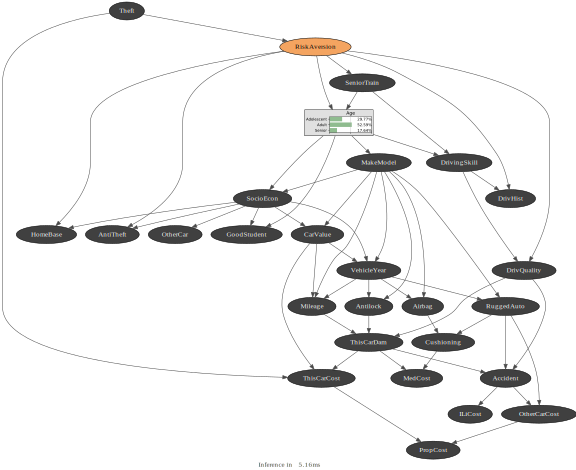

In [12]:
res = gnb.showInference(model = bn, engine = gum.LazyPropagation(bn), evs = {"RiskAversion" : "Psychopath"}, targets = ["Age"], view = "graph")


In [13]:
#bn.cpt(1).variable(1).domain()

bn.variableFromName("Age").labels()

('Adolescent', 'Adult', 'Senior')

In [14]:
ie=gum.LazyPropagation(bn)
#ie.makeInference()
ie.addEvidence("RiskAversion","Cautious")
ie.addJointTarget(set(["Accident", "ILiCost"]))
print(ie.jointPosterior(set(["Accident", "ILiCost"])))


      ||  Accident                             |
ILiCos||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Hundre|| 0.0000  | 0.0020  | 0.0001  | 0.0043  |
Millio|| 0.0000  | 0.0013  | 0.0001  | 0.0042  |
TenTho|| 0.0000  | 0.0030  | 0.0001  | 0.0073  |
Thousa|| 0.0644  | 0.0476  | 0.8023  | 0.0633  |



In [15]:
l = np.unique(y_train.to_numpy())
print(sorted(l))

['Mild', 'Moderate', 'None', 'Severe']


In [16]:
def powerset(iterable,depth = np.inf):
    s = list(iterable)
    tmp = list(chain.from_iterable(combinations(s, r) for r in range(min(len(s),depth)+1)))
    return tmp

In [17]:
def omega(variable, data) :
    return list(data[variable].unique())

In [18]:
omega("Age",X)

['Adult', 'Senior', 'Adolescent']

In [19]:
def reduce_dataset(instance, X,y) :
    print(instance)
    columns = list(X.columns)
    #columns.remove("index")
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            print(columns[i], " is evidence!")
            X = X[X[columns[i]] == value]
            X = X.drop(columns[i], axis=1)
        else :
            print(columns[i], " is unobserved")
    y = y[[j for j in y.index if j in X.index]]
    return X,y

In [218]:
def list_diff(list1, list2) :
    diff = []
    for i in list1 :
        if i not in list2 :
            diff.append(i)
    return diff

def prune_network(bn, ev_vars, hyp_vars, supp_vars = None) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    print(bn_pr.names())
    for i in supp_vars :
        print(i)
        print(hyp_vars)
        print(ev_vars)
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def map_query(bn, ev_vars, hyp_vars) :
    return propagate_evidence(bn, ev_vars, joint_targets = [hyp_vars]).jointPosterior(set(hyp_vars))


def propagate_evidence(bn, ev_vars, joint_targets = []) :
    ie=gum.LazyPropagation(bn)
    for i in joint_targets :
        ie.addJointTarget(set(i))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    return ie
            
    
def omega(variables, data = None , bn = None) :
    domains = []
    if bn is not None :
        for variable in variables :
            domains.append(sorted(bn.variableFromName(variable).labels()))
    else :
        for variable in variables :
            domains.append(sorted(data[variable].unique()))
    return [p for p in product(*domains)]
    

def prepare_mapi(instances, variables) :
     #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    evidence_set = []
    # For each instance:
    for instance in instances :
        # Check which are the evidence variables
        evidence = dict()
        for i,value in enumerate(instance) :
            if isinstance(value, str) or not math.isnan(value) :
                evidence[variables[i]] = value
        evidence_set.append(evidence)
    return evidence_set
    

# True if R is relevant/MAP-dependent
# False if R is irrelevant/MAP-independent
def map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None, hyp_posterior = None, return_jsd = False) : 
    # Check which are the supplementary (missing) variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
    # Check if R in unobserved
    #print(supp_vars)
    for R in set_R :
        if R not in supp_vars :
            raise Exception("The variable", R, "is in the set R but is not a supplementary node")
    y = hyp_vars_assign
    posterior = hyp_posterior
    if y is None :    
        # Perform a MAP-query and get the argmax from the posterior. 
        # Check if a posterior for P(H|e) was provided
        if hyp_posterior is None :
            posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
            y = posterior.argmax()[0][0]
        else :
            y = posterior.argmax()[0][0]
    # Obtain domain of R
    omega_R = omega(set_R, bn = bn)
    # For each value assignment r in omega(R)
    jsd = 0
    for value_assignment_r in omega_R :
        # Fill in values
        ev_vars_alt = ev_vars.copy()
        for i,value in enumerate(value_assignment_r) :
            ev_vars_alt[set_R[i]] = value
        #print(instance)
        #print(instance_alt)
        # Inference with evidence and r
        posterior_alt = map_query(bn, ev_vars = ev_vars_alt, hyp_vars = hyp_vars)
        y_alt = posterior_alt.argmax()[0][0]
        # Check if we need to compute the jsd divergence between P(H|e) and P(H|e,r)
        if return_jsd :
            jsd = max(jsd, JSD(posterior,posterior_alt))
        # Comparar con prediccion de instance
        #print(value_assignment_r)
        #print(y, " == ", y_alt)
        #print(posterior.argmax()[1], "--", posterior_alt.argmax()[1])
        if y != y_alt :
            if return_jsd :
                return True, jsd
            else :
                return True
    if return_jsd:
        return False, jsd
    else :
        return False
    
def map_independence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None, hyp_posterior = None, return_jsd = False) : 
    if return_jsd :
        mapd, jsd = map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign,
                                   hyp_posterior = hyp_posterior, return_jsd = True)
        return (not mapd, jsd)
    else :
        return not map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign,
                                  hyp_posterior = hyp_posterior, return_jsd = False)

def e_map_independence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None, hyp_posterior = None, return_jsd = False) : 
    # Check which are the supplementary (missing) variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
    # Check if R in unobserved
    #print(supp_vars)
    for R in set_R :
        if R not in supp_vars :
            raise Exception("The variable", R, "is in the set R but is not a supplementary node")
    y = hyp_vars_assign
    posterior = hyp_posterior
    if y is None :    
        # Perform a MAP-query and get the argmax from the posterior. 
        # Check if a posterior for P(H|e) was provided
        if hyp_posterior is None :
            posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
            y = posterior.argmax()[0][0]
        else :
            y = posterior.argmax()[0][0]
    # Obtain domain of R
    omega_R = omega(set_R, bn = bn)
    # For each value assignment r in omega(R)
    jsd = 0
    for value_assignment_r in omega_R :
        # Fill in values
        ev_vars_alt = ev_vars.copy()
        for i,value in enumerate(value_assignment_r) :
            ev_vars_alt[set_R[i]] = value
        # Inference with evidence and r
        posterior_alt = map_query(bn, ev_vars = ev_vars_alt, hyp_vars = hyp_vars)
        # Compute the jsd divergence between P(H|e) and P(H|e,r)
        jsd = max(jsd, JSD(posterior,posterior_alt))
    return jsd

In [21]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))
bn_pr = prune_network(bn, ["DrivingSkill", "RiskAversion"], ["DrivHist"])
#bn_pr.names()

swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python dete

In [22]:
map_query(bn, ev_vars = {'RiskAversion':"Psychopath"}, hyp_vars = ["Accident"]).argmax()[0][0]

{'Accident': 2}

In [23]:
map_independence(bn, ["ILiCost"], {'RiskAversion':"Psychopath"}, ["Accident"])

False

In [24]:
omega(["RiskAversion", "DrivingSkill"], bn = bn)

[('Adventurous', 'Expert'),
 ('Adventurous', 'Normal'),
 ('Adventurous', 'SubStandard'),
 ('Cautious', 'Expert'),
 ('Cautious', 'Normal'),
 ('Cautious', 'SubStandard'),
 ('Normal', 'Expert'),
 ('Normal', 'Normal'),
 ('Normal', 'SubStandard'),
 ('Psychopath', 'Expert'),
 ('Psychopath', 'Normal'),
 ('Psychopath', 'SubStandard')]

In [25]:
def check_every_r_bn(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    S = powerset(supp_vars,depth = depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        for j in S_split[i] :
            # If relevant
            print(list(j))
            if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                relevant_sets.append(j)
                # Apply prune
                for k in range(i+1,len(S_split)) :
                    tmp = []
                    for l in S_split[k] :
                        if set(j).issubset(set(l)) :
                            relevant_sets.append(l)
                        else :
                            tmp.append(l)
                    S_split[k] = tmp
            # If irrelevant
            else :
                irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_by_ev

In [254]:
def get_c_exp(bn, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    print(hyp_vars_assign)
    if hyp_vars_assign is None :
        posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
        hyp_vars_assign = posterior.argmax()[0][0]
    
    # Alternative. First compute P(H|e) and then P(e) and compute the product
    ie=gum.LazyPropagation(bn)
    ie.addJointTarget(set(hyp_vars))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    post = ie.jointPosterior(set(hyp_vars))

    # Compute P(e)
    ie=gum.LazyPropagation(bn)
    ie.setEvidence(ev_vars)
    ie.makeInference()
    p_e = ie.evidenceProbability()
    
    post = post * p_e
    inst = gum.Instantiation(post)
    inst.fromdict(hyp_vars_assign)
    P_eh = post.get(inst)
    return post/P_eh

def decomposition_prune(relevant_set, S_split, relevant_sets) :
    i = len(relevant_set)
    for k in range(i,len(S_split)) :
        tmp = []
        for l in S_split[k] :
            if set(relevant_set).issubset(set(l)) :
                relevant_sets.append(l)
            else :
                tmp.append(l)
        S_split[k] = tmp
    return S_split, relevant_sets

def conditional_independence_prune(irrelevant_set, S_split, irrelevant_sets) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def check_every_r_silja(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars)
    bn_pr = bn
    #print(dsep_by_ev)
    
    #tmp = supp_vars
    #supp_vars = []
    
    #for i in tmp :
    #    if i not in dsep_by_ev :
    #        supp_vars.append(i)
    
    S = powerset(supp_vars,depth=depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)

    
    time.sleep(1)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn_pr, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    h_star = list()
    # Value assignment y, but in a different format
    for key in posterior.argmax()[0][0].keys() :
        h_star.append(bn_pr.variableFromName(key).labels()[posterior.argmax()[0][0][key]])
    h_star = tuple(h_star)
        
    for i in range(0,len(S_split)) :
        if i == 0 :
            c_exp = get_c_exp(bn_pr, ev_vars, hyp_vars, hyp_vars_assign = y)
            inst_c = gum.Instantiation(c_exp)

            to_prop = ev_vars.copy()
            to_prop.update(y)
            ie_max = propagate_evidence(bn_pr, to_prop)

            relevant_singletons = []
            new_S_split = S_split
            for j in S_split[0] :
                # If relevant
                if ie_max.posterior(j[0]).argmin()[1] == 0 :
                    relevant_sets.append(j)
                    relevant_singletons.append(j)
                    # Apply prune
                    new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets)
            S_split = new_S_split
            S_split[0] = list_diff(S_split[0], relevant_singletons)
            
            
            print("Relevancies: ")
            print(relevant_sets)
            print("To eval: ")
            print(S_split[0])

            omega_h = omega(hyp_vars, bn = bn_pr)

            #print(omega_h)
            #print(y)
            #print(c_exp)
            if len(S_split[0]) > 0 :
                for h_i in omega_h :
                    print(h_i," == ",h_star)
                    if h_i == h_star :
                        continue
                    print(h_i)
                    print(y)
                    to_prop = ev_vars.copy()
                    to_prop.update(dict(zip(hyp_vars, list(h_i))))
                    ie = propagate_evidence(bn_pr, to_prop)

                    inst_c.fromdict(to_prop)
                    c_i = math.log(c_exp.get(inst_c))

                    relevant_singletons = []
                    new_S_split = S_split
                    for j in S_split[0] :
                        post_max = ie_max.posterior(j[0])
                        post = ie.posterior(j[0])
                        inst_h = gum.Instantiation(post)
                        while not inst_h.end() and not math.log(post.get(inst_h) / post_max.get(inst_h)) + c_i > 0 :
                            inst_h.inc()
                        if not inst_h.end() :
                            relevant_sets.append(j)
                            relevant_singletons.append(j)
                            # Apply prune
                            new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets) 
                    #print(S_split[0])
                    #print(relevant_singletons)
                    S_split = new_S_split
                    S_split[0] = list_diff(S_split[0], relevant_singletons)
                    #print(S_split[0])
                    # Modifico S_split[0] mientras 

                for j in S_split[0] :
                    irrelevant_sets.append(j)

        else : 
            new_S_split = S_split
            for j in S_split[i] :
                # If relevant
                print(list(j))
                if map_dependence(bn, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                    relevant_sets.append(j)
                    # Apply prune
                    new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets)
                    # Bro, que estás iterando sobre S_split. No puedes cambiar la variable
                # If irrelevant
                else :
                    irrelevant_sets.append(j)
            S_split = new_S_split
    return relevant_sets, irrelevant_sets, dsep_by_ev

In [27]:
ev_vars = {'RiskAversion':"Psychopath"}
hyp_vars = ["Accident", "ILiCost", "Age"]
joint_target = hyp_vars #list(ev_vars.keys()) + 
#joint_target = sorted(joint_target)
ie=gum.LazyPropagation(bn)
#joint_target = ["Accident", "ILiCost", "RiskAversion"]
ie.addJointTarget(set(joint_target))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(joint_target))
post

(pyAgrum.Potential<double>@0x3626430) 
             ||  Accident                             |
Age   |ILiCos||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Adoles|Hundre|| 0.0000  | 0.0015  | 0.0000  | 0.0035  |
Adult |Hundre|| 0.0001  | 0.0022  | 0.0000  | 0.0053  |
Senior|Hundre|| 0.0000  | 0.0008  | 0.0000  | 0.0018  |
Adoles|Millio|| 0.0000  | 0.0010  | 0.0000  | 0.0035  |
Adult |Millio|| 0.0001  | 0.0015  | 0.0000  | 0.0052  |
Senior|Millio|| 0.0000  | 0.0005  | 0.0000  | 0.0018  |
Adoles|TenTho|| 0.0000  | 0.0023  | 0.0000  | 0.0060  |
Adult |TenTho|| 0.0001  | 0.0034  | 0.0000  | 0.0090  |
Senior|TenTho|| 0.0000  | 0.0012  | 0.0000  | 0.0031  |
Adoles|Thousa|| 0.0449  | 0.0363  | 0.1462  | 0.0524  |
Adult |Thousa|| 0.0677  | 0.0543  | 0.2990  | 0.0780  |
Senior|Thousa|| 0.0249  | 0.0196  | 0.0952  | 0.0273  |

In [28]:
t = list()
for key in post.argmax()[0][0].keys() :
    print(bn.variableFromName(key).labels()[post.argmax()[0][0][key]])
    t.append(bn.variableFromName(key).labels()[post.argmax()[0][0][key]])
print(tuple(t))

None
Adult
Thousand
('None', 'Adult', 'Thousand')


In [29]:
# JSD divergence
def JSD(potential_1, potential_2) :
    mean = (potential_1+potential_2)/2
    return (potential_1.KL(mean) + potential_2.KL(mean))/2

In [30]:
get_c_exp(bn, ev_vars, hyp_vars)

None


(pyAgrum.Potential<double>@0x4cecec0) 
             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0001  | 0.0050  | 0.0000  | 0.0119  |
Millio|Adoles|| 0.0001  | 0.0033  | 0.0000  | 0.0116  |
TenTho|Adoles|| 0.0001  | 0.0076  | 0.0000  | 0.0202  |
Thousa|Adoles|| 0.1501  | 0.1214  | 0.4889  | 0.1752  |
Hundre|Adult || 0.0002  | 0.0075  | 0.0001  | 0.0177  |
Millio|Adult || 0.0002  | 0.0049  | 0.0001  | 0.0173  |
TenTho|Adult || 0.0002  | 0.0114  | 0.0001  | 0.0301  |
Thousa|Adult || 0.2264  | 0.1817  | 1.0000  | 0.2608  |
Hundre|Senior|| 0.0001  | 0.0027  | 0.0000  | 0.0062  |
Millio|Senior|| 0.0001  | 0.0018  | 0.0000  | 0.0060  |
TenTho|Senior|| 0.0001  | 0.0041  | 0.0000  | 0.0105  |
Thousa|Senior|| 0.0831  | 0.0656  | 0.3183  | 0.0911  |

In [31]:
# Alternative. First compute P(H|e) and then P(e) and compute the product
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(hyp_vars))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(hyp_vars))

# Compute P(e)
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(ev_vars.keys()))
ie.makeInference()
p_e = ie.jointPosterior(set(ev_vars.keys()))
inst_e = gum.Instantiation(p_e)
inst_e.fromdict(ev_vars)

post = post * p_e.get(inst_e)


In [32]:
print(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Millio|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Thousa|Adoles|| 0.0006  | 0.0005  | 0.0020  | 0.0007  |
Hundre|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Millio|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
TenTho|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Thousa|Adult || 0.0009  | 0.0007  | 0.0041  | 0.0011  |
Hundre|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Millio|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Thousa|Senior|| 0.0003  | 0.0003  | 0.0013  | 0.0004  |



In [33]:
c_exp = post/post.argmax()[1]
print(c_exp)
inst = gum.Instantiation(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0001  | 0.0050  | 0.0000  | 0.0119  |
Millio|Adoles|| 0.0001  | 0.0033  | 0.0000  | 0.0116  |
TenTho|Adoles|| 0.0001  | 0.0076  | 0.0000  | 0.0202  |
Thousa|Adoles|| 0.1501  | 0.1214  | 0.4889  | 0.1752  |
Hundre|Adult || 0.0002  | 0.0075  | 0.0001  | 0.0177  |
Millio|Adult || 0.0002  | 0.0049  | 0.0001  | 0.0173  |
TenTho|Adult || 0.0002  | 0.0114  | 0.0001  | 0.0301  |
Thousa|Adult || 0.2264  | 0.1817  | 1.0000  | 0.2608  |
Hundre|Senior|| 0.0001  | 0.0027  | 0.0000  | 0.0062  |
Millio|Senior|| 0.0001  | 0.0018  | 0.0000  | 0.0060  |
TenTho|Senior|| 0.0001  | 0.0041  | 0.0000  | 0.0105  |
Thousa|Senior|| 0.0831  | 0.0656  | 0.3183  | 0.0911  |



In [34]:
print("Inicio")
prueba = X_test.head(1).to_numpy()
prueba[0][4:26] = np.nan
print("Prueba")
t0 = time.time()
relevant_sets_sj, irrelevant_sets_sj, dsep_nodes_sj = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_silja = tf-t0
print("Silja: ",tf-t0)
t0 = time.time()
relevant_sets, irrelevant_sets, dsep_nodes = check_every_r_bn(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_orig = tf-t0
print("Original")

Inicio
Prueba
nd.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found

In [35]:
print("Silja: ",t_silja)
print("Original: ",t_orig)

Silja:  1.0383946895599365
Original:  0.04551553726196289


In [36]:
print(relevant_sets)
print(relevant_sets_sj)

[('MedCost',), ('DrivQuality',), ('OtherCarCost',), ('ILiCost',), ('ThisCarCost',), ('ThisCarDam',), ('PropCost',), ('DrivingSkill',)]
[('MedCost',), ('OtherCarCost',), ('ThisCarCost',), ('ThisCarDam',), ('PropCost',), ('ILiCost',), ('DrivQuality',), ('DrivingSkill',)]


In [37]:
print(irrelevant_sets)
print(irrelevant_sets_sj)

[('SeniorTrain',), ('Airbag',), ('DrivHist',), ('VehicleYear',), ('Antilock',), ('CarValue',), ('Mileage',), ('MakeModel',), ('Cushioning',), ('RuggedAuto',)]
[('SeniorTrain',), ('Airbag',), ('DrivHist',), ('VehicleYear',), ('Antilock',), ('CarValue',), ('AntiTheft',), ('Mileage',), ('MakeModel',), ('HomeBase',), ('Cushioning',), ('RuggedAuto',), ('OtherCar',), ('Theft',)]


In [39]:
def hypothesis(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
                
    S = powerset(supp_vars,depth =depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    to_ret = []
    irr_ratio = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        if i < depth :
            irr = 0
            total = 0
            for j in S_split[i] :
                # If relevant
                print(list(j))
                mapd = map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
                to_ret.append((mapd[0],mapd[1],len(j)))
                if not mapd[0] :
                    irr = irr +1
                total = total +1
            irr_ratio.append(irr/total)
    return to_ret, irr_ratio

In [40]:
prueba = X_test.head(1).to_numpy()
prueba[0][5:26] = np.nan
hyp, irr_ratio = hypothesis(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 5)

structor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.


['MedCost', 'DrivHist', 'ThisCarDam']
['MedCost', 'DrivHist', 'Mileage']
['MedCost', 'DrivHist', 'PropCost']
['MedCost', 'DrivHist', 'MakeModel']
['MedCost', 'DrivHist', 'Cushioning']
['MedCost', 'DrivHist', 'DrivingSkill']
['MedCost', 'DrivHist', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarCost']
['MedCost', 'ILiCost', 'Antilock']
['MedCost', 'ILiCost', 'CarValue']
['MedCost', 'ILiCost', 'ThisCarDam']
['MedCost', 'ILiCost', 'Mileage']
['MedCost', 'ILiCost', 'PropCost']
['MedCost', 'ILiCost', 'MakeModel']
['MedCost', 'ILiCost', 'Cushioning']
['MedCost', 'ILiCost', 'DrivingSkill']
['MedCost', 'ILiCost', 'RuggedAuto']
['MedCost', 'ThisCarCost', 'Antilock']
['MedCost', 'ThisCarCost', 'CarValue']
['MedCost', 'ThisCarCost', 'ThisCarDam']
['MedCost', 'ThisCarCost', 'Mileage']
['MedCost', 'ThisCarCost', 'PropCost']
['MedCost', 'ThisCarCost', 'MakeModel']
['MedCost', 'ThisCarCost', 'Cushioning']
['MedCost', 'ThisCarCost', 'DrivingSkill']
['MedCost', 'ThisCarCost', 'RuggedAuto']
['MedCost', 'A

['OtherCarCost', 'Antilock', 'ThisCarDam']
['OtherCarCost', 'Antilock', 'Mileage']
['OtherCarCost', 'Antilock', 'PropCost']
['OtherCarCost', 'Antilock', 'MakeModel']
['OtherCarCost', 'Antilock', 'Cushioning']
['OtherCarCost', 'Antilock', 'DrivingSkill']
['OtherCarCost', 'Antilock', 'RuggedAuto']
['OtherCarCost', 'CarValue', 'ThisCarDam']
['OtherCarCost', 'CarValue', 'Mileage']
['OtherCarCost', 'CarValue', 'PropCost']
['OtherCarCost', 'CarValue', 'MakeModel']
['OtherCarCost', 'CarValue', 'Cushioning']
['OtherCarCost', 'CarValue', 'DrivingSkill']
['OtherCarCost', 'CarValue', 'RuggedAuto']
['OtherCarCost', 'ThisCarDam', 'Mileage']
['OtherCarCost', 'ThisCarDam', 'PropCost']
['OtherCarCost', 'ThisCarDam', 'MakeModel']
['OtherCarCost', 'ThisCarDam', 'Cushioning']
['OtherCarCost', 'ThisCarDam', 'DrivingSkill']
['OtherCarCost', 'ThisCarDam', 'RuggedAuto']
['OtherCarCost', 'Mileage', 'PropCost']
['OtherCarCost', 'Mileage', 'MakeModel']
['OtherCarCost', 'Mileage', 'Cushioning']
['OtherCarCost', 

['DrivHist', 'CarValue', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'Mileage']
['DrivHist', 'ThisCarDam', 'PropCost']
['DrivHist', 'ThisCarDam', 'MakeModel']
['DrivHist', 'ThisCarDam', 'Cushioning']
['DrivHist', 'ThisCarDam', 'DrivingSkill']
['DrivHist', 'ThisCarDam', 'RuggedAuto']
['DrivHist', 'Mileage', 'PropCost']
['DrivHist', 'Mileage', 'MakeModel']
['DrivHist', 'Mileage', 'Cushioning']
['DrivHist', 'Mileage', 'DrivingSkill']
['DrivHist', 'Mileage', 'RuggedAuto']
['DrivHist', 'PropCost', 'MakeModel']
['DrivHist', 'PropCost', 'Cushioning']
['DrivHist', 'PropCost', 'DrivingSkill']
['DrivHist', 'PropCost', 'RuggedAuto']
['DrivHist', 'MakeModel', 'Cushioning']
['DrivHist', 'MakeModel', 'DrivingSkill']
['DrivHist', 'MakeModel', 'RuggedAuto']
['DrivHist', 'Cushioning', 'DrivingSkill']
['DrivHist', 'Cushioning', 'RuggedAuto']
['DrivHist', 'DrivingSkill', 'RuggedAuto']
['ILiCost', 'ThisCarCost', 'Antilock']
['ILiCost', 'ThisCarCost', 'CarValue']
['ILiCost', 'ThisCarCost', 'ThisCarDam']
['ILi

['MedCost', 'DrivQuality', 'Antilock', 'ThisCarDam']
['MedCost', 'DrivQuality', 'Antilock', 'Mileage']
['MedCost', 'DrivQuality', 'Antilock', 'PropCost']
['MedCost', 'DrivQuality', 'Antilock', 'MakeModel']
['MedCost', 'DrivQuality', 'Antilock', 'Cushioning']
['MedCost', 'DrivQuality', 'Antilock', 'DrivingSkill']
['MedCost', 'DrivQuality', 'Antilock', 'RuggedAuto']
['MedCost', 'DrivQuality', 'CarValue', 'ThisCarDam']
['MedCost', 'DrivQuality', 'CarValue', 'Mileage']
['MedCost', 'DrivQuality', 'CarValue', 'PropCost']
['MedCost', 'DrivQuality', 'CarValue', 'MakeModel']
['MedCost', 'DrivQuality', 'CarValue', 'Cushioning']
['MedCost', 'DrivQuality', 'CarValue', 'DrivingSkill']
['MedCost', 'DrivQuality', 'CarValue', 'RuggedAuto']
['MedCost', 'DrivQuality', 'ThisCarDam', 'Mileage']
['MedCost', 'DrivQuality', 'ThisCarDam', 'PropCost']
['MedCost', 'DrivQuality', 'ThisCarDam', 'MakeModel']
['MedCost', 'DrivQuality', 'ThisCarDam', 'Cushioning']
['MedCost', 'DrivQuality', 'ThisCarDam', 'DrivingSki

['MedCost', 'SeniorTrain', 'Mileage', 'MakeModel']
['MedCost', 'SeniorTrain', 'Mileage', 'Cushioning']
['MedCost', 'SeniorTrain', 'Mileage', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'Mileage', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'PropCost', 'MakeModel']
['MedCost', 'SeniorTrain', 'PropCost', 'Cushioning']
['MedCost', 'SeniorTrain', 'PropCost', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'PropCost', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'MakeModel', 'Cushioning']
['MedCost', 'SeniorTrain', 'MakeModel', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'MakeModel', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'Cushioning', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'Cushioning', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'Airbag', 'DrivHist', 'ILiCost']
['MedCost', 'Airbag', 'DrivHist', 'ThisCarCost']
['MedCost', 'Airbag', 'DrivHist', 'Antilock']
['MedCost', 'Airbag', 'DrivHist', 'CarValue']
['MedCost', 'Airbag', 'DrivHist', 'ThisCarDam']
['MedCost',

['MedCost', 'ThisCarCost', 'Antilock', 'Cushioning']
['MedCost', 'ThisCarCost', 'Antilock', 'DrivingSkill']
['MedCost', 'ThisCarCost', 'Antilock', 'RuggedAuto']
['MedCost', 'ThisCarCost', 'CarValue', 'ThisCarDam']
['MedCost', 'ThisCarCost', 'CarValue', 'Mileage']
['MedCost', 'ThisCarCost', 'CarValue', 'PropCost']
['MedCost', 'ThisCarCost', 'CarValue', 'MakeModel']
['MedCost', 'ThisCarCost', 'CarValue', 'Cushioning']
['MedCost', 'ThisCarCost', 'CarValue', 'DrivingSkill']
['MedCost', 'ThisCarCost', 'CarValue', 'RuggedAuto']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'Mileage']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'PropCost']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'MakeModel']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'Cushioning']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'DrivingSkill']
['MedCost', 'ThisCarCost', 'ThisCarDam', 'RuggedAuto']
['MedCost', 'ThisCarCost', 'Mileage', 'PropCost']
['MedCost', 'ThisCarCost', 'Mileage', 'MakeModel']
['MedCost', 'ThisCarCost', 'Mileage', 'Cushio

['DrivQuality', 'OtherCarCost', 'PropCost', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'MakeModel', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'SeniorTrain', 'Airbag', 'DrivHist']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ILiCost']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarCost']
['DrivQuality', 'SeniorTrain', 'Airbag', 'Antilock']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam']
['DrivQuality', 'SeniorTrain', 'Airbag', 'Mileage']
['DrivQuality', 'SeniorTrain', 'Airbag', 'PropCost']
['DrivQuality', 'SeniorTrain', 'Airbag', 'MakeModel']
['DrivQuality', 'SeniorTrain', 'Airbag', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'Airbag', 'D

['DrivQuality', 'Airbag', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'DrivHist', 'ILiCost', 'ThisCarCost']
['DrivQuality', 'DrivHist', 'ILiCost', 'Antilock']
['DrivQuality', 'DrivHist', 'ILiCost', 'CarValue']
['DrivQuality', 'DrivHist', 'ILiCost', 'ThisCarDam']
['DrivQuality', 'DrivHist', 'ILiCost', 'Mileage']
['DrivQuality', 'DrivHist', 'ILiCost', 'PropCost']
['DrivQuality', 'DrivHist', 'ILiCost', 'MakeModel']
['DrivQuality', 'DrivHist', 'ILiCost', 'Cushioning']
['DrivQuality', 'DrivHist', 'ILiCost', 'DrivingSkill']
['DrivQuality', 'DrivHist', 'ILiCost', 'RuggedAuto']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'Antilock']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'CarValue']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'ThisCarDam']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'Mileage']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'PropCost']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'MakeModel']
['DrivQuality', 'DrivHist', 'ThisCarCost', 'Cushioning']
['DrivQuality', 'DrivHist', 'Thi

['DrivQuality', 'Antilock', 'PropCost', 'MakeModel']
['DrivQuality', 'Antilock', 'PropCost', 'Cushioning']
['DrivQuality', 'Antilock', 'PropCost', 'DrivingSkill']
['DrivQuality', 'Antilock', 'PropCost', 'RuggedAuto']
['DrivQuality', 'Antilock', 'MakeModel', 'Cushioning']
['DrivQuality', 'Antilock', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'Antilock', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'Antilock', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'Antilock', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'Antilock', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'CarValue', 'ThisCarDam', 'Mileage']
['DrivQuality', 'CarValue', 'ThisCarDam', 'PropCost']
['DrivQuality', 'CarValue', 'ThisCarDam', 'MakeModel']
['DrivQuality', 'CarValue', 'ThisCarDam', 'Cushioning']
['DrivQuality', 'CarValue', 'ThisCarDam', 'DrivingSkill']
['DrivQuality', 'CarValue', 'ThisCarDam', 'RuggedAuto']
['DrivQuality', 'CarValue', 'Mileage', 'PropCost']
['DrivQuality', 'CarValue', 'Mileage', 'MakeModel']
['DrivQua

['OtherCarCost', 'Airbag', 'MakeModel', 'Cushioning']
['OtherCarCost', 'Airbag', 'MakeModel', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost']
['OtherCarCost', 'DrivHist', 'ILiCost', 'Antilock']
['OtherCarCost', 'DrivHist', 'ILiCost', 'CarValue']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarDam']
['OtherCarCost', 'DrivHist', 'ILiCost', 'Mileage']
['OtherCarCost', 'DrivHist', 'ILiCost', 'PropCost']
['OtherCarCost', 'DrivHist', 'ILiCost', 'MakeModel']
['OtherCarCost', 'DrivHist', 'ILiCost', 'Cushioning']
['OtherCarCost', 'DrivHist', 'ILiCost', 'DrivingSkill']
['OtherCarCost', 'DrivHist', 'ILiCost', 'RuggedAuto']
['OtherCarCost', 'DrivHist', 'ThisCarCost', 'Antilock']
['OtherCarCost', 'DrivHist', 'ThisCarCost', 'CarValue']
['OtherCarCost', 'Driv

['OtherCarCost', 'ThisCarDam', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'ThisCarDam', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'ThisCarDam', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'ThisCarDam', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'Mileage', 'PropCost', 'MakeModel']
['OtherCarCost', 'Mileage', 'PropCost', 'Cushioning']
['OtherCarCost', 'Mileage', 'PropCost', 'DrivingSkill']
['OtherCarCost', 'Mileage', 'PropCost', 'RuggedAuto']
['OtherCarCost', 'Mileage', 'MakeModel', 'Cushioning']
['OtherCarCost', 'Mileage', 'MakeModel', 'DrivingSkill']
['OtherCarCost', 'Mileage', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'Mileage', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'Mileage', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'PropCost', 'MakeModel', 'Cushioning']
['OtherCarCost', 'PropCost', 'MakeModel', 'DrivingSkill']
['OtherCarCost', 'PropCost', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'PropCost', 'Cushi

['SeniorTrain', 'ILiCost', 'Mileage', 'MakeModel']
['SeniorTrain', 'ILiCost', 'Mileage', 'Cushioning']
['SeniorTrain', 'ILiCost', 'Mileage', 'DrivingSkill']
['SeniorTrain', 'ILiCost', 'Mileage', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'PropCost', 'MakeModel']
['SeniorTrain', 'ILiCost', 'PropCost', 'Cushioning']
['SeniorTrain', 'ILiCost', 'PropCost', 'DrivingSkill']
['SeniorTrain', 'ILiCost', 'PropCost', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'MakeModel', 'Cushioning']
['SeniorTrain', 'ILiCost', 'MakeModel', 'DrivingSkill']
['SeniorTrain', 'ILiCost', 'MakeModel', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'Cushioning', 'DrivingSkill']
['SeniorTrain', 'ILiCost', 'Cushioning', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'Antilock', 'CarValue']
['SeniorTrain', 'ThisCarCost', 'Antilock', 'ThisCarDam']
['SeniorTrain', 'ThisCarCost', 'Antilock', 'Mileage']
['SeniorTrain', 'ThisCarCost', 'Antilock', 'PropCost']
['SeniorTrain', 'ThisCar

['Airbag', 'DrivHist', 'CarValue', 'RuggedAuto']
['Airbag', 'DrivHist', 'ThisCarDam', 'Mileage']
['Airbag', 'DrivHist', 'ThisCarDam', 'PropCost']
['Airbag', 'DrivHist', 'ThisCarDam', 'MakeModel']
['Airbag', 'DrivHist', 'ThisCarDam', 'Cushioning']
['Airbag', 'DrivHist', 'ThisCarDam', 'DrivingSkill']
['Airbag', 'DrivHist', 'ThisCarDam', 'RuggedAuto']
['Airbag', 'DrivHist', 'Mileage', 'PropCost']
['Airbag', 'DrivHist', 'Mileage', 'MakeModel']
['Airbag', 'DrivHist', 'Mileage', 'Cushioning']
['Airbag', 'DrivHist', 'Mileage', 'DrivingSkill']
['Airbag', 'DrivHist', 'Mileage', 'RuggedAuto']
['Airbag', 'DrivHist', 'PropCost', 'MakeModel']
['Airbag', 'DrivHist', 'PropCost', 'Cushioning']
['Airbag', 'DrivHist', 'PropCost', 'DrivingSkill']
['Airbag', 'DrivHist', 'PropCost', 'RuggedAuto']
['Airbag', 'DrivHist', 'MakeModel', 'Cushioning']
['Airbag', 'DrivHist', 'MakeModel', 'DrivingSkill']
['Airbag', 'DrivHist', 'MakeModel', 'RuggedAuto']
['Airbag', 'DrivHist', 'Cushioning', 'DrivingSkill']
['Airbag

['Airbag', 'Mileage', 'Cushioning', 'DrivingSkill']
['Airbag', 'Mileage', 'Cushioning', 'RuggedAuto']
['Airbag', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'PropCost', 'MakeModel', 'Cushioning']
['Airbag', 'PropCost', 'MakeModel', 'DrivingSkill']
['Airbag', 'PropCost', 'MakeModel', 'RuggedAuto']
['Airbag', 'PropCost', 'Cushioning', 'DrivingSkill']
['Airbag', 'PropCost', 'Cushioning', 'RuggedAuto']
['Airbag', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'MakeModel', 'Cushioning', 'DrivingSkill']
['Airbag', 'MakeModel', 'Cushioning', 'RuggedAuto']
['Airbag', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'ILiCost', 'ThisCarCost', 'Antilock']
['DrivHist', 'ILiCost', 'ThisCarCost', 'CarValue']
['DrivHist', 'ILiCost', 'ThisCarCost', 'ThisCarDam']
['DrivHist', 'ILiCost', 'ThisCarCost', 'Mileage']
['DrivHist', 'ILiCost', 'ThisCarCost', 'PropCost']
['DrivHist', 'ILiCost', 'ThisCarCost', 'MakeModel']
['DrivHist', '

['DrivHist', 'MakeModel', 'Cushioning', 'RuggedAuto']
['DrivHist', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['ILiCost', 'ThisCarCost', 'Antilock', 'CarValue']
['ILiCost', 'ThisCarCost', 'Antilock', 'ThisCarDam']
['ILiCost', 'ThisCarCost', 'Antilock', 'Mileage']
['ILiCost', 'ThisCarCost', 'Antilock', 'PropCost']
['ILiCost', 'ThisCarCost', 'Antilock', 'MakeModel']
['ILiCost', 'ThisCarCost', 'Antilock', 'Cushioning']
['ILiCost', 'ThisCarCost', 'Antilock', 'DrivingSkill']
['ILiCost', 'ThisCarCost', 'Antilock', 'RuggedAuto']
['ILiCost', 'ThisCarCost', 'CarValue', 'ThisCarDam']
['ILiCost', 'ThisCarCost', 'CarValue', 'Mileage']
['ILiCost', 'ThisCarCost', 'CarValue', 'PropCost']
['ILiCost', 'ThisCarCost', 'CarValue', 'MakeModel']
['ILiCost', 'ThisCarCost', 'CarValue', 'Cushioning']
['ILiCost', 'ThisCarCost', 'CarValue', 'DrivingSkill']
['ILiCost', 'ThisCarCost', 'CarValue', 'RuggedAuto']
['ILiCost', 'ThisCarCost', 'ThisCarDam', 'Mileag

['ThisCarCost', 'Mileage', 'PropCost', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'MakeModel', 'Cushioning']
['ThisCarCost', 'Mileage', 'MakeModel', 'DrivingSkill']
['ThisCarCost', 'Mileage', 'MakeModel', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'Cushioning', 'DrivingSkill']
['ThisCarCost', 'Mileage', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'MakeModel', 'Cushioning']
['ThisCarCost', 'PropCost', 'MakeModel', 'DrivingSkill']
['ThisCarCost', 'PropCost', 'MakeModel', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'Cushioning', 'DrivingSkill']
['ThisCarCost', 'PropCost', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'MakeModel', 'Cushioning', 'DrivingSkill']
['ThisCarCost', 'MakeModel', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['Antilock', 'CarValue', 'ThisCarDam', '

['MedCost', 'DrivQuality', 'OtherCarCost', 'MakeModel', 'Cushioning']
['MedCost', 'DrivQuality', 'OtherCarCost', 'MakeModel', 'DrivingSkill']
['MedCost', 'DrivQuality', 'OtherCarCost', 'MakeModel', 'RuggedAuto']
['MedCost', 'DrivQuality', 'OtherCarCost', 'Cushioning', 'DrivingSkill']
['MedCost', 'DrivQuality', 'OtherCarCost', 'Cushioning', 'RuggedAuto']
['MedCost', 'DrivQuality', 'OtherCarCost', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'DrivHist']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'ILiCost']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarCost']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'Antilock']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'Mileage']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'PropCost']
['MedCost', 'DrivQuality', 'SeniorTrain', 'Airbag', 'Mak

['MedCost', 'DrivQuality', 'DrivHist', 'CarValue', 'DrivingSkill']
['MedCost', 'DrivQuality', 'DrivHist', 'CarValue', 'RuggedAuto']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'Mileage']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'PropCost']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'MakeModel']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'Cushioning']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'DrivingSkill']
['MedCost', 'DrivQuality', 'DrivHist', 'ThisCarDam', 'RuggedAuto']
['MedCost', 'DrivQuality', 'DrivHist', 'Mileage', 'PropCost']
['MedCost', 'DrivQuality', 'DrivHist', 'Mileage', 'MakeModel']
['MedCost', 'DrivQuality', 'DrivHist', 'Mileage', 'Cushioning']
['MedCost', 'DrivQuality', 'DrivHist', 'Mileage', 'DrivingSkill']
['MedCost', 'DrivQuality', 'DrivHist', 'Mileage', 'RuggedAuto']
['MedCost', 'DrivQuality', 'DrivHist', 'PropCost', 'MakeModel']
['MedCost', 'DrivQuality', 'DrivHist', 'PropCost', 'Cushioning']
['MedCost', 'DrivQuali

['MedCost', 'DrivQuality', 'PropCost', 'Cushioning', 'DrivingSkill']
['MedCost', 'DrivQuality', 'PropCost', 'Cushioning', 'RuggedAuto']
['MedCost', 'DrivQuality', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'DrivQuality', 'MakeModel', 'Cushioning', 'DrivingSkill']
['MedCost', 'DrivQuality', 'MakeModel', 'Cushioning', 'RuggedAuto']
['MedCost', 'DrivQuality', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'DrivQuality', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'DrivHist']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'ILiCost']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'ThisCarCost']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'Antilock']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'CarValue']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'ThisCarDam']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'Mileage']
['MedCost', 'OtherCarCost', 'SeniorTrain', 'Airbag', 'Prop

['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'ThisCarDam']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'Mileage']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'PropCost']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'MakeModel']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'Cushioning']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'DrivHist', 'Antilock', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'ThisCarDam']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'Mileage']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'PropCost']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'MakeModel']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'Cushioning']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'DrivHist', 'CarValue', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'DrivHist', 'ThisCarDam', 'Mileage']
['MedCost', 'OtherC

['MedCost', 'OtherCarCost', 'CarValue', 'MakeModel', 'Cushioning']
['MedCost', 'OtherCarCost', 'CarValue', 'MakeModel', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'CarValue', 'MakeModel', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'CarValue', 'Cushioning', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'CarValue', 'Cushioning', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'CarValue', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'Mileage', 'PropCost']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'Mileage', 'MakeModel']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'Mileage', 'Cushioning']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'Mileage', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'Mileage', 'RuggedAuto']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'PropCost', 'MakeModel']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'PropCost', 'Cushioning']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'PropCost', 'DrivingSkill']
['MedCost', 'OtherCarCost', 'ThisCarDam', 'PropCos

['MedCost', 'SeniorTrain', 'ILiCost', 'Mileage', 'MakeModel']
['MedCost', 'SeniorTrain', 'ILiCost', 'Mileage', 'Cushioning']
['MedCost', 'SeniorTrain', 'ILiCost', 'Mileage', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'ILiCost', 'Mileage', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'ILiCost', 'PropCost', 'MakeModel']
['MedCost', 'SeniorTrain', 'ILiCost', 'PropCost', 'Cushioning']
['MedCost', 'SeniorTrain', 'ILiCost', 'PropCost', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'ILiCost', 'PropCost', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'ILiCost', 'MakeModel', 'Cushioning']
['MedCost', 'SeniorTrain', 'ILiCost', 'MakeModel', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'ILiCost', 'MakeModel', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'ILiCost', 'Cushioning', 'DrivingSkill']
['MedCost', 'SeniorTrain', 'ILiCost', 'Cushioning', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'ILiCost', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'SeniorTrain', 'ThisCarCost', 'Antilock', 'CarValue']
['MedCost', 'SeniorTrain'

['MedCost', 'Airbag', 'DrivHist', 'Cushioning', 'DrivingSkill']
['MedCost', 'Airbag', 'DrivHist', 'Cushioning', 'RuggedAuto']
['MedCost', 'Airbag', 'DrivHist', 'DrivingSkill', 'RuggedAuto']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'Antilock']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'CarValue']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'ThisCarDam']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'Mileage']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'PropCost']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'MakeModel']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'Cushioning']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'DrivingSkill']
['MedCost', 'Airbag', 'ILiCost', 'ThisCarCost', 'RuggedAuto']
['MedCost', 'Airbag', 'ILiCost', 'Antilock', 'CarValue']
['MedCost', 'Airbag', 'ILiCost', 'Antilock', 'ThisCarDam']
['MedCost', 'Airbag', 'ILiCost', 'Antilock', 'Mileage']
['MedCost', 'Airbag', 'ILiCost', 'Antilock', 'PropCost']
['MedCost', 'Airbag', 'ILiCost'

['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'CarValue']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'ThisCarDam']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'Mileage']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'PropCost']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'MakeModel']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'Cushioning']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'DrivingSkill']
['MedCost', 'DrivHist', 'ILiCost', 'Antilock', 'RuggedAuto']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'ThisCarDam']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'Mileage']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'PropCost']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'MakeModel']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'Cushioning']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'DrivingSkill']
['MedCost', 'DrivHist', 'ILiCost', 'CarValue', 'RuggedAuto']
['MedCost', 'DrivHist', 'ILiCost', 'ThisCarDam', 'Mileage']
['MedCost', 'DrivHist', 'ILiCost', 

['MedCost', 'ILiCost', 'ThisCarCost', 'ThisCarDam', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'PropCost']
['MedCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'MakeModel']
['MedCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'Cushioning']
['MedCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'DrivingSkill']
['MedCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'MakeModel']
['MedCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'Cushioning']
['MedCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'DrivingSkill']
['MedCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'Cushioning']
['MedCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'DrivingSkill']
['MedCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarCost', 'Cushioning', 'DrivingSkill']
['MedCost', 'ILiCost', 'ThisCarCost', 'Cushioning', 'RuggedAuto']
['MedCost', 'ILiCost', 'ThisCarC

['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'Mileage']
['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'PropCost']
['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'MakeModel']
['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'Cushioning']
['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'DrivingSkill']
['MedCost', 'Antilock', 'CarValue', 'ThisCarDam', 'RuggedAuto']
['MedCost', 'Antilock', 'CarValue', 'Mileage', 'PropCost']
['MedCost', 'Antilock', 'CarValue', 'Mileage', 'MakeModel']
['MedCost', 'Antilock', 'CarValue', 'Mileage', 'Cushioning']
['MedCost', 'Antilock', 'CarValue', 'Mileage', 'DrivingSkill']
['MedCost', 'Antilock', 'CarValue', 'Mileage', 'RuggedAuto']
['MedCost', 'Antilock', 'CarValue', 'PropCost', 'MakeModel']
['MedCost', 'Antilock', 'CarValue', 'PropCost', 'Cushioning']
['MedCost', 'Antilock', 'CarValue', 'PropCost', 'DrivingSkill']
['MedCost', 'Antilock', 'CarValue', 'PropCost', 'RuggedAuto']
['MedCost', 'Antilock', 'CarValue', 'MakeModel', 'Cushioning']
['Me

['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'CarValue', 'MakeModel']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'CarValue', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'CarValue', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'CarValue', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'Mileage']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'PropCost']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'MakeModel']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'ThisCarDam', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'Mileage', 'PropCost']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'Mileage', 'MakeModel']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', 'Mileage', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'SeniorTrain', '

['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'PropCost', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'MakeModel', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'ThisCarCost', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'ThisCarDam']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'Mileage']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'PropCost']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'MakeModel']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'Cushioning']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'DrivingSkill']
['DrivQuality', 'OtherCarCost', 'Antilock', 'CarValue', 'R

['DrivQuality', 'SeniorTrain', 'Airbag', 'Antilock', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'Airbag', 'Antilock', 'DrivingSkill']
['DrivQuality', 'SeniorTrain', 'Airbag', 'Antilock', 'RuggedAuto']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'ThisCarDam']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'Mileage']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'PropCost']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'MakeModel']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'DrivingSkill']
['DrivQuality', 'SeniorTrain', 'Airbag', 'CarValue', 'RuggedAuto']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam', 'Mileage']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam', 'PropCost']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam', 'MakeModel']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'Airbag', 'ThisCarDam', 'Drivin

['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'Antilock', 'MakeModel']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'Antilock', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'Antilock', 'DrivingSkill']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'Antilock', 'RuggedAuto']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'ThisCarDam']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'Mileage']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'PropCost']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'MakeModel']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'Cushioning']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'DrivingSkill']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'CarValue', 'RuggedAuto']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'ThisCarDam', 'Mileage']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'ThisCarDam', 'PropCost']
['DrivQuality', 'SeniorTrain', 'ThisCarCost', 'ThisCarDam', 'MakeMod

['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'ThisCarDam']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'Mileage']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'PropCost']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'MakeModel']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'Cushioning']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'DrivingSkill']
['DrivQuality', 'Airbag', 'DrivHist', 'Antilock', 'RuggedAuto']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'ThisCarDam']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'Mileage']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'PropCost']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'MakeModel']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'Cushioning']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'DrivingSkill']
['DrivQuality', 'Airbag', 'DrivHist', 'CarValue', 'RuggedAuto']
['DrivQuality', 'Airbag', 'DrivHist', 'ThisCarDam', 'Mileage']
['DrivQuality', 'Airbag', 'DrivHist', 'ThisCarDam

['DrivQuality', 'Airbag', 'Antilock', 'Mileage', 'DrivingSkill']
['DrivQuality', 'Airbag', 'Antilock', 'Mileage', 'RuggedAuto']
['DrivQuality', 'Airbag', 'Antilock', 'PropCost', 'MakeModel']
['DrivQuality', 'Airbag', 'Antilock', 'PropCost', 'Cushioning']
['DrivQuality', 'Airbag', 'Antilock', 'PropCost', 'DrivingSkill']
['DrivQuality', 'Airbag', 'Antilock', 'PropCost', 'RuggedAuto']
['DrivQuality', 'Airbag', 'Antilock', 'MakeModel', 'Cushioning']
['DrivQuality', 'Airbag', 'Antilock', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'Airbag', 'Antilock', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'Airbag', 'Antilock', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'Airbag', 'Antilock', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'Airbag', 'Antilock', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'Airbag', 'CarValue', 'ThisCarDam', 'Mileage']
['DrivQuality', 'Airbag', 'CarValue', 'ThisCarDam', 'PropCost']
['DrivQuality', 'Airbag', 'CarValue', 'ThisCarDam', 'MakeModel']
['DrivQuality', 'Airbag'

['DrivQuality', 'DrivHist', 'Antilock', 'CarValue', 'PropCost']
['DrivQuality', 'DrivHist', 'Antilock', 'CarValue', 'MakeModel']
['DrivQuality', 'DrivHist', 'Antilock', 'CarValue', 'Cushioning']
['DrivQuality', 'DrivHist', 'Antilock', 'CarValue', 'DrivingSkill']
['DrivQuality', 'DrivHist', 'Antilock', 'CarValue', 'RuggedAuto']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'Mileage']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'PropCost']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'MakeModel']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'Cushioning']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'DrivingSkill']
['DrivQuality', 'DrivHist', 'Antilock', 'ThisCarDam', 'RuggedAuto']
['DrivQuality', 'DrivHist', 'Antilock', 'Mileage', 'PropCost']
['DrivQuality', 'DrivHist', 'Antilock', 'Mileage', 'MakeModel']
['DrivQuality', 'DrivHist', 'Antilock', 'Mileage', 'Cushioning']
['DrivQuality', 'DrivHist', 'Antilock', 'Mileage', 'DrivingSkill']
['DrivQu

['DrivQuality', 'ILiCost', 'PropCost', 'MakeModel', 'Cushioning']
['DrivQuality', 'ILiCost', 'PropCost', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'ILiCost', 'PropCost', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'ILiCost', 'PropCost', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'ILiCost', 'PropCost', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'ILiCost', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'ILiCost', 'MakeModel', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'ILiCost', 'MakeModel', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'ILiCost', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'ILiCost', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'ThisCarCost', 'Antilock', 'CarValue', 'ThisCarDam']
['DrivQuality', 'ThisCarCost', 'Antilock', 'CarValue', 'Mileage']
['DrivQuality', 'ThisCarCost', 'Antilock', 'CarValue', 'PropCost']
['DrivQuality', 'ThisCarCost', 'Antilock', 'CarValue', 'MakeModel']
['DrivQuality', 'ThisCarCost', 'Antilock', 'Ca

['DrivQuality', 'Antilock', 'Mileage', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'Antilock', 'Mileage', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'Antilock', 'Mileage', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'Antilock', 'Mileage', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'Antilock', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'Antilock', 'PropCost', 'MakeModel', 'Cushioning']
['DrivQuality', 'Antilock', 'PropCost', 'MakeModel', 'DrivingSkill']
['DrivQuality', 'Antilock', 'PropCost', 'MakeModel', 'RuggedAuto']
['DrivQuality', 'Antilock', 'PropCost', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'Antilock', 'PropCost', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'Antilock', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'Antilock', 'MakeModel', 'Cushioning', 'DrivingSkill']
['DrivQuality', 'Antilock', 'MakeModel', 'Cushioning', 'RuggedAuto']
['DrivQuality', 'Antilock', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['DrivQuality', 'Antilock', 'Cushioning

['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'Mileage']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'PropCost']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'MakeModel']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'Cushioning']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'DrivingSkill']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'ThisCarDam', 'RuggedAuto']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'Mileage', 'PropCost']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'Mileage', 'MakeModel']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'Mileage', 'Cushioning']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'Mileage', 'DrivingSkill']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'Mileage', 'RuggedAuto']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'PropCost', 'MakeModel']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'PropCost', 'Cushioning']
['OtherCarCost', 'SeniorTrain', 'DrivHist', 'PropCost', 'DrivingSkill']
['OtherCarCost', 

['OtherCarCost', 'Airbag', 'DrivHist', 'ThisCarCost', 'PropCost']
['OtherCarCost', 'Airbag', 'DrivHist', 'ThisCarCost', 'MakeModel']
['OtherCarCost', 'Airbag', 'DrivHist', 'ThisCarCost', 'Cushioning']
['OtherCarCost', 'Airbag', 'DrivHist', 'ThisCarCost', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'DrivHist', 'ThisCarCost', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'CarValue']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'ThisCarDam']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'Mileage']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'PropCost']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'MakeModel']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'Cushioning']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'DrivHist', 'Antilock', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'DrivHist', 'CarValue', 'ThisCarDam']
['OtherCarCost', 'Airbag', 'DrivHist', 'CarValue', 'Mileage']
['OtherCarCost', 'Ai

['OtherCarCost', 'Airbag', 'PropCost', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'PropCost', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'MakeModel', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'Airbag', 'MakeModel', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'Airbag', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Antilock']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'CarValue']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'ThisCarDam']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Mileage']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'PropCost']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'MakeModel']
['OtherCarCost', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Cushioning']
['OtherCarCost', 'DrivHist', 'ILiCost', 'Th

['OtherCarCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'DrivingSkill']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'Mileage', 'RuggedAuto']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'MakeModel']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'Cushioning']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'DrivingSkill']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'PropCost', 'RuggedAuto']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'Cushioning']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'DrivingSkill']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'ILiCost', 'ThisCarCost', 'DrivingSkill', 'RuggedAuto']
['OtherCarCost', 'ILiCost', 'Antilock', 'CarValue', 'ThisCarDam']
['OtherCarCost', 'ILiCost', 'Antilock', 'CarValue', 'Mileage']
['OtherCarCost', 'ILiCost',

['OtherCarCost', 'Antilock', 'ThisCarDam', 'Mileage', 'PropCost']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Mileage', 'MakeModel']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Mileage', 'Cushioning']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Mileage', 'DrivingSkill']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Mileage', 'RuggedAuto']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'PropCost', 'MakeModel']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'PropCost', 'Cushioning']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'PropCost', 'DrivingSkill']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'PropCost', 'RuggedAuto']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'MakeModel', 'Cushioning']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'MakeModel', 'DrivingSkill']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'MakeModel', 'RuggedAuto']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Cushioning', 'DrivingSkill']
['OtherCarCost', 'Antilock', 'ThisCarDam', 'Cushioning', 'RuggedAuto']
['OtherCarCost', 'Antilock',

['SeniorTrain', 'Airbag', 'ILiCost', 'Mileage', 'Cushioning']
['SeniorTrain', 'Airbag', 'ILiCost', 'Mileage', 'DrivingSkill']
['SeniorTrain', 'Airbag', 'ILiCost', 'Mileage', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'ILiCost', 'PropCost', 'MakeModel']
['SeniorTrain', 'Airbag', 'ILiCost', 'PropCost', 'Cushioning']
['SeniorTrain', 'Airbag', 'ILiCost', 'PropCost', 'DrivingSkill']
['SeniorTrain', 'Airbag', 'ILiCost', 'PropCost', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'ILiCost', 'MakeModel', 'Cushioning']
['SeniorTrain', 'Airbag', 'ILiCost', 'MakeModel', 'DrivingSkill']
['SeniorTrain', 'Airbag', 'ILiCost', 'MakeModel', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'ILiCost', 'Cushioning', 'DrivingSkill']
['SeniorTrain', 'Airbag', 'ILiCost', 'Cushioning', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'ILiCost', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'ThisCarCost', 'Antilock', 'CarValue']
['SeniorTrain', 'Airbag', 'ThisCarCost', 'Antilock', 'ThisCarDam']
['SeniorTrain', 'Airbag', 'ThisCar

['SeniorTrain', 'Airbag', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'Airbag', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Antilock']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'CarValue']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'ThisCarDam']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Mileage']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'PropCost']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'MakeModel']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Cushioning']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'DrivingSkill']
['SeniorTrain', 'DrivHist', 'ILiCost', 'ThisCarCost', 'RuggedAuto']
['SeniorTrain', 'DrivHist', 'ILiCost', 'Antilock', 'CarValue']
['SeniorTrain', 'DrivHist', 'ILiCost', 'Antilock', 'ThisCarDam']
['SeniorTrain', 'DrivHist', 'ILiCost', 'Antilock', 'Mileage']
['SeniorTrain', 'DrivHist', 'ILiCost', 'Antilock', 'PropCost']
['Se

['SeniorTrain', 'DrivHist', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'CarValue']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'ThisCarDam']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'Mileage']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'PropCost']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'MakeModel']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'Cushioning']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'DrivingSkill']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'Antilock', 'RuggedAuto']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'ThisCarDam']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'Mileage']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'PropCost']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'MakeModel']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'Cushioning']
['SeniorTrain', 'ILiCost', 'ThisCarCost', 'CarValue', 'D

['SeniorTrain', 'ThisCarCost', 'PropCost', 'MakeModel', 'Cushioning']
['SeniorTrain', 'ThisCarCost', 'PropCost', 'MakeModel', 'DrivingSkill']
['SeniorTrain', 'ThisCarCost', 'PropCost', 'MakeModel', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'PropCost', 'Cushioning', 'DrivingSkill']
['SeniorTrain', 'ThisCarCost', 'PropCost', 'Cushioning', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'MakeModel', 'Cushioning', 'DrivingSkill']
['SeniorTrain', 'ThisCarCost', 'MakeModel', 'Cushioning', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'ThisCarCost', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'Antilock', 'CarValue', 'ThisCarDam', 'Mileage']
['SeniorTrain', 'Antilock', 'CarValue', 'ThisCarDam', 'PropCost']
['SeniorTrain', 'Antilock', 'CarValue', 'ThisCarDam', 'MakeModel']
['SeniorTrain', 'Antilock', 'CarValue', 'ThisCarDam', 'Cushioning']
['SeniorTr

['SeniorTrain', 'Mileage', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'Mileage', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'PropCost', 'MakeModel', 'Cushioning', 'DrivingSkill']
['SeniorTrain', 'PropCost', 'MakeModel', 'Cushioning', 'RuggedAuto']
['SeniorTrain', 'PropCost', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'PropCost', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['SeniorTrain', 'MakeModel', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Antilock']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'CarValue']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'ThisCarDam']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Mileage']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'PropCost']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'MakeModel']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'Cushioning']
['Airbag', 'DrivHist', 'ILiCost', 'ThisCarCost', 'DrivingSkill']
['Airba

['Airbag', 'DrivHist', 'Mileage', 'Cushioning', 'DrivingSkill']
['Airbag', 'DrivHist', 'Mileage', 'Cushioning', 'RuggedAuto']
['Airbag', 'DrivHist', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'DrivHist', 'PropCost', 'MakeModel', 'Cushioning']
['Airbag', 'DrivHist', 'PropCost', 'MakeModel', 'DrivingSkill']
['Airbag', 'DrivHist', 'PropCost', 'MakeModel', 'RuggedAuto']
['Airbag', 'DrivHist', 'PropCost', 'Cushioning', 'DrivingSkill']
['Airbag', 'DrivHist', 'PropCost', 'Cushioning', 'RuggedAuto']
['Airbag', 'DrivHist', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'DrivHist', 'MakeModel', 'Cushioning', 'DrivingSkill']
['Airbag', 'DrivHist', 'MakeModel', 'Cushioning', 'RuggedAuto']
['Airbag', 'DrivHist', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'DrivHist', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'ILiCost', 'ThisCarCost', 'Antilock', 'CarValue']
['Airbag', 'ILiCost', 'ThisCarCost', 'Antilock', 'ThisCarDam']
['Airbag', 'ILiCost', 'ThisCarCost', 'Anti

['Airbag', 'ThisCarCost', 'CarValue', 'Mileage', 'RuggedAuto']
['Airbag', 'ThisCarCost', 'CarValue', 'PropCost', 'MakeModel']
['Airbag', 'ThisCarCost', 'CarValue', 'PropCost', 'Cushioning']
['Airbag', 'ThisCarCost', 'CarValue', 'PropCost', 'DrivingSkill']
['Airbag', 'ThisCarCost', 'CarValue', 'PropCost', 'RuggedAuto']
['Airbag', 'ThisCarCost', 'CarValue', 'MakeModel', 'Cushioning']
['Airbag', 'ThisCarCost', 'CarValue', 'MakeModel', 'DrivingSkill']
['Airbag', 'ThisCarCost', 'CarValue', 'MakeModel', 'RuggedAuto']
['Airbag', 'ThisCarCost', 'CarValue', 'Cushioning', 'DrivingSkill']
['Airbag', 'ThisCarCost', 'CarValue', 'Cushioning', 'RuggedAuto']
['Airbag', 'ThisCarCost', 'CarValue', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'PropCost']
['Airbag', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'MakeModel']
['Airbag', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'Cushioning']
['Airbag', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'DrivingSkill']
['Airbag', 'ThisCarCos

['Airbag', 'CarValue', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'CarValue', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'Mileage', 'PropCost', 'MakeModel']
['Airbag', 'ThisCarDam', 'Mileage', 'PropCost', 'Cushioning']
['Airbag', 'ThisCarDam', 'Mileage', 'PropCost', 'DrivingSkill']
['Airbag', 'ThisCarDam', 'Mileage', 'PropCost', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'Mileage', 'MakeModel', 'Cushioning']
['Airbag', 'ThisCarDam', 'Mileage', 'MakeModel', 'DrivingSkill']
['Airbag', 'ThisCarDam', 'Mileage', 'MakeModel', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'Mileage', 'Cushioning', 'DrivingSkill']
['Airbag', 'ThisCarDam', 'Mileage', 'Cushioning', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'PropCost', 'MakeModel', 'Cushioning']
['Airbag', 'ThisCarDam', 'PropCost', 'MakeModel', 'DrivingSkill']
['Airbag', 'ThisCarDam', 'PropCost', 'MakeModel', 'RuggedAuto']
['Airbag', 'ThisCarDam', 'PropCost', 

['DrivHist', 'ThisCarCost', 'CarValue', 'PropCost', 'Cushioning']
['DrivHist', 'ThisCarCost', 'CarValue', 'PropCost', 'DrivingSkill']
['DrivHist', 'ThisCarCost', 'CarValue', 'PropCost', 'RuggedAuto']
['DrivHist', 'ThisCarCost', 'CarValue', 'MakeModel', 'Cushioning']
['DrivHist', 'ThisCarCost', 'CarValue', 'MakeModel', 'DrivingSkill']
['DrivHist', 'ThisCarCost', 'CarValue', 'MakeModel', 'RuggedAuto']
['DrivHist', 'ThisCarCost', 'CarValue', 'Cushioning', 'DrivingSkill']
['DrivHist', 'ThisCarCost', 'CarValue', 'Cushioning', 'RuggedAuto']
['DrivHist', 'ThisCarCost', 'CarValue', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'PropCost']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'MakeModel']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'Cushioning']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'DrivingSkill']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'Mileage', 'RuggedAuto']
['DrivHist', 'ThisCarCost', 'ThisCarDam', 'PropCost', '

['DrivHist', 'ThisCarDam', 'PropCost', 'MakeModel', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'PropCost', 'Cushioning', 'DrivingSkill']
['DrivHist', 'ThisCarDam', 'PropCost', 'Cushioning', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'MakeModel', 'Cushioning', 'DrivingSkill']
['DrivHist', 'ThisCarDam', 'MakeModel', 'Cushioning', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'ThisCarDam', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'Mileage', 'PropCost', 'MakeModel', 'Cushioning']
['DrivHist', 'Mileage', 'PropCost', 'MakeModel', 'DrivingSkill']
['DrivHist', 'Mileage', 'PropCost', 'MakeModel', 'RuggedAuto']
['DrivHist', 'Mileage', 'PropCost', 'Cushioning', 'DrivingSkill']
['DrivHist', 'Mileage', 'PropCost', 'Cushioning', 'RuggedAuto']
['DrivHist', 'Mileage', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['DrivHist', 'Mileage', 'MakeModel', 'Cushioning', 'DrivingSkil

['ILiCost', 'CarValue', 'Mileage', 'PropCost', 'DrivingSkill']
['ILiCost', 'CarValue', 'Mileage', 'PropCost', 'RuggedAuto']
['ILiCost', 'CarValue', 'Mileage', 'MakeModel', 'Cushioning']
['ILiCost', 'CarValue', 'Mileage', 'MakeModel', 'DrivingSkill']
['ILiCost', 'CarValue', 'Mileage', 'MakeModel', 'RuggedAuto']
['ILiCost', 'CarValue', 'Mileage', 'Cushioning', 'DrivingSkill']
['ILiCost', 'CarValue', 'Mileage', 'Cushioning', 'RuggedAuto']
['ILiCost', 'CarValue', 'Mileage', 'DrivingSkill', 'RuggedAuto']
['ILiCost', 'CarValue', 'PropCost', 'MakeModel', 'Cushioning']
['ILiCost', 'CarValue', 'PropCost', 'MakeModel', 'DrivingSkill']
['ILiCost', 'CarValue', 'PropCost', 'MakeModel', 'RuggedAuto']
['ILiCost', 'CarValue', 'PropCost', 'Cushioning', 'DrivingSkill']
['ILiCost', 'CarValue', 'PropCost', 'Cushioning', 'RuggedAuto']
['ILiCost', 'CarValue', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['ILiCost', 'CarValue', 'MakeModel', 'Cushioning', 'DrivingSkill']
['ILiCost', 'CarValue', 'MakeModel', 'Cus

['ThisCarCost', 'Mileage', 'PropCost', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'PropCost', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'MakeModel', 'Cushioning', 'DrivingSkill']
['ThisCarCost', 'Mileage', 'MakeModel', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'Mileage', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'MakeModel', 'Cushioning', 'DrivingSkill']
['ThisCarCost', 'PropCost', 'MakeModel', 'Cushioning', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'MakeModel', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'PropCost', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['ThisCarCost', 'MakeModel', 'Cushioning', 'DrivingSkill', 'RuggedAuto']
['Antilock', 'CarValue', 'ThisCarDam', 'Mileage', 'PropCost']
['Antilock', 'CarValue', 'ThisCarDam', 'Mileage', 'MakeModel']
['Antilock', 'CarValue', 'ThisCarDam', 'Mileage', 'Cushioning']
['Antilock', 'CarValue', 'ThisCarDam', '

In [41]:
unzip_hyp = list(zip(*hyp))

only_irr = []
only_rel = []
for i in hyp :
    if not i[0] :
        only_irr.append(i)
    else :
        only_rel.append(i)
only_irr_unzip = list(zip(*only_irr))
only_rel_unzip = list(zip(*only_rel))

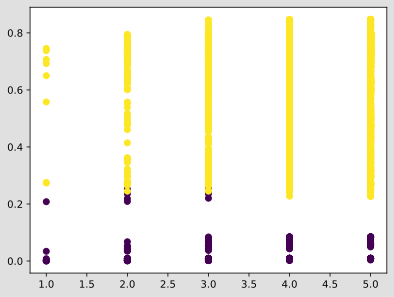

In [42]:
import matplotlib.pyplot as plt

plt.scatter(unzip_hyp[2], unzip_hyp[1], c = unzip_hyp[0])

In [43]:
irr_ratio

[0.5294117647058824,
 0.23529411764705882,
 0.08823529411764706,
 0.029831932773109245,
 0.00904977375565611]

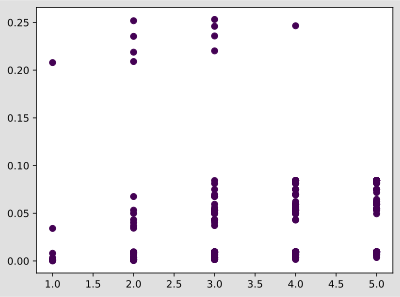

In [44]:
plt.scatter(only_irr_unzip[2], only_irr_unzip[1], c = only_irr_unzip[0])

In [45]:
plt.scatter(list(range(0,len(unzip_hyp[1]))),unzip_hyp[1], c = unzip_hyp[0])

In [46]:
ks_res = stats.kstest(unzip_hyp[0],unzip_hyp[1])
ks_res[1]

0.0

In [47]:
def hill_climbing(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    irrelevant_singletons = []
    
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    min_jsd = np.inf
    most_irrel = None
    for i in supp_vars :
        #print(ev_vars, hyp_vars, [i])
        irrel, jsd = map_independence(bn_pr, set_R = [i], ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
        if irrel :
            irrelevant_singletons.append(i)
            if jsd < min_jsd :
                min_jsd = jsd
                most_irrel = i
    if most_irrel is None :
        return 
    current_irrelevant_set = [most_irrel]
    irrelevant_singletons.remove(most_irrel)
    current_depth = 1
    
    while current_depth < depth and len(irrelevant_singletons)>0 :
        min_jsd = np.inf
        most_irrel = None
        new_irrelevant_singletons = irrelevant_singletons
        for i in irrelevant_singletons :
            current_copy = current_irrelevant_set.copy()
            current_copy.append(i)
            irrel, jsd = map_independence(bn_pr, set_R = current_copy, ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
            if irrel :
                if jsd < min_jsd :
                    min_jsd = jsd
                    most_irrel = i
            else :
                new_irrelevant_singletons.remove(i)
                
        if most_irrel is None :
            return current_irrelevant_set
        irrelevant_singletons = new_irrelevant_singletons
        current_irrelevant_set.append(most_irrel)
        irrelevant_singletons.remove(most_irrel)
        current_depth = current_depth+1
            
    return current_irrelevant_set


def hill_climbing2(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    irrelevant_singletons = dict()
    
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    # For singletons
    for i in supp_vars :
        #print(ev_vars, hyp_vars, [i])
        irrel, jsd = map_independence(bn_pr, set_R = [i], ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
        if irrel :
            irrelevant_singletons[i] = jsd
    if len(irrelevant_singletons.keys()) == 0 :
        return []
    
    irrelevant_singletons = {k: v for k, v in sorted(irrelevant_singletons.items(), key=lambda item: item[1])}
    current_irrelevant_set = [next(iter(irrelevant_singletons))]
    del irrelevant_singletons[next(iter(irrelevant_singletons))]
    print(irrelevant_singletons)

    current_depth = 1
    
    # For higher order sets
    while current_depth < depth and len(irrelevant_singletons)>0 :
        new_irrelevant_singletons = irrelevant_singletons.copy()
        for i in irrelevant_singletons.keys() :
            print(new_irrelevant_singletons)
            current_copy = current_irrelevant_set.copy()
            current_copy.append(i)
            new_irrelevant_singletons.pop(i)
            print(current_copy)
            irrel, jsd = map_independence(bn_pr, set_R = current_copy, ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
            if irrel :
                current_irrelevant_set = current_copy
                break
        irrelevant_singletons = new_irrelevant_singletons
        current_depth = current_depth+1
            
    return current_irrelevant_set

In [48]:
t_silja = []
t_hill = []
for i in range(5,10) :
    prueba = X_test.head(1).to_numpy()
    prueba[0][0:i] = np.nan
    t0 = time.time()
    relevant_sets_sj, irrelevant_sets_sj, dsep_nodes_sj = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_silja.append(tf-t0)
    print("Silja: ",tf-t0)
    t0 = time.time()
    irrelevant_set = hill_climbing(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_hill.append(tf-t0)
    print("Prune: ",tf-t0)

{'Accident': 2}
Relevancies: 
[]
To eval: 
[('VehicleYear',), ('SocioEcon',), ('RiskAversion',), ('Age',), ('GoodStudent',)]
('Mild',)  ==  ('None',)
('Mild',)
{'Accident': 2}
('Moderate',)  ==  ('None',)
('Moderate',)
{'Accident': 2}
('None',)  ==  ('None',)
('Severe',)  ==  ('None',)
('Severe',)
{'Accident': 2}
['VehicleYear', 'SocioEcon']
['VehicleYear', 'RiskAversion']
['VehicleYear', 'Age']
['VehicleYear', 'GoodStudent']
['SocioEcon', 'RiskAversion']
['SocioEcon', 'Age']
['SocioEcon', 'GoodStudent']
['RiskAversion', 'Age']
['RiskAversion', 'GoodStudent']
['Age', 'GoodStudent']
['VehicleYear', 'SocioEcon', 'RiskAversion']
['VehicleYear', 'SocioEcon', 'Age']
['VehicleYear', 'SocioEcon', 'GoodStudent']
['VehicleYear', 'RiskAversion', 'Age']
['VehicleYear', 'RiskAversion', 'GoodStudent']
['VehicleYear', 'Age', 'GoodStudent']
['SocioEcon', 'RiskAversion', 'Age']
['SocioEcon', 'RiskAversion', 'GoodStudent']
['SocioEcon', 'Age', 'GoodStudent']
['RiskAversion', 'Age', 'GoodStudent']
['Veh

swig/python detected a memory leak of type 'gum::NodeS{'Accident': 2}
Relevancies: 
[]
To eval: 
[('VehicleYear',), ('ThisCarDam',), ('SocioEcon',), ('RiskAversion',), ('Age',), ('RuggedAuto',), ('GoodStudent',)]
('Mild',)  ==  ('None',)
('Mild',)
{'Accident': 2}
('Moderate',)  ==  ('None',)
('Moderate',)
{'Accident': 2}
('None',)  ==  ('None',)
('Severe',)  ==  ('None',)
('Severe',)
{'Accident': 2}
['VehicleYear', 'SocioEcon']
['VehicleYear', 'RiskAversion']
['VehicleYear', 'Age']
['VehicleYear', 'RuggedAuto']
['VehicleYear', 'GoodStudent']
['SocioEcon', 'RiskAversion']
['SocioEcon', 'Age']
['SocioEcon', 'RuggedAuto']
['SocioEcon', 'GoodStudent']
['RiskAversion', 'Age']
['RiskAversion', 'RuggedAuto']
['RiskAversion', 'GoodStudent']
['Age', 'RuggedAuto']
['Age', 'GoodStudent']
['RuggedAuto', 'GoodStudent']
['VehicleYear', 'SocioEcon', 'RiskAversion']
['VehicleYear', 'SocioEcon', 'Age']
['VehicleYear', 'SocioEcon', 'RuggedAuto']
['VehicleYear', 'SocioEcon', 'GoodStudent']
['VehicleYear'

['VehicleYear', 'MakeModel', 'RiskAversion']
['VehicleYear', 'MakeModel', 'Age']
['VehicleYear', 'MakeModel', 'RuggedAuto']
['VehicleYear', 'MakeModel', 'GoodStudent']
['VehicleYear', 'RiskAversion', 'Age']
['VehicleYear', 'RiskAversion', 'RuggedAuto']
['VehicleYear', 'RiskAversion', 'GoodStudent']
['VehicleYear', 'Age', 'RuggedAuto']
['VehicleYear', 'Age', 'GoodStudent']
['VehicleYear', 'RuggedAuto', 'GoodStudent']
['SocioEcon', 'MakeModel', 'RiskAversion']
['SocioEcon', 'MakeModel', 'Age']
['SocioEcon', 'MakeModel', 'RuggedAuto']
['SocioEcon', 'MakeModel', 'GoodStudent']
['SocioEcon', 'RiskAversion', 'Age']
['SocioEcon', 'RiskAversion', 'RuggedAuto']
['SocioEcon', 'RiskAversion', 'GoodStudent']
['SocioEcon', 'Age', 'RuggedAuto']
['SocioEcon', 'Age', 'GoodStudent']
['SocioEcon', 'RuggedAuto', 'GoodStudent']
['MakeModel', 'RiskAversion', 'Age']
['MakeModel', 'RiskAversion', 'RuggedAuto']
['MakeModel', 'RiskAversion', 'GoodStudent']
['MakeModel', 'Age', 'RuggedAuto']
['MakeModel', 'Age'

swig/python detected a memory leak of type 'gu{'Accident': 2}
Relevancies: 
[]
To eval: 
[('DrivQuality',), ('VehicleYear',), ('ThisCarDam',), ('SocioEcon',), ('MakeModel',), ('RiskAversion',), ('Age',), ('RuggedAuto',), ('GoodStudent',)]
('Mild',)  ==  ('None',)
('Mild',)
{'Accident': 2}
('Moderate',)  ==  ('None',)
('Moderate',)
{'Accident': 2}
('None',)  ==  ('None',)
('Severe',)  ==  ('None',)
('Severe',)
{'Accident': 2}
['DrivQuality', 'VehicleYear']
['DrivQuality', 'SocioEcon']
['DrivQuality', 'MakeModel']
['DrivQuality', 'RiskAversion']
['DrivQuality', 'Age']
['DrivQuality', 'RuggedAuto']
['DrivQuality', 'GoodStudent']
['VehicleYear', 'SocioEcon']
['VehicleYear', 'MakeModel']
['VehicleYear', 'RiskAversion']
['VehicleYear', 'Age']
['VehicleYear', 'RuggedAuto']
['VehicleYear', 'GoodStudent']
['SocioEcon', 'MakeModel']
['SocioEcon', 'RiskAversion']
['SocioEcon', 'Age']
['SocioEcon', 'RuggedAuto']
['SocioEcon', 'GoodStudent']
['MakeModel', 'RiskAversion']
['MakeModel', 'Age']
['Make

['DrivQuality', 'VehicleYear', 'MakeModel', 'RiskAversion', 'GoodStudent']
['DrivQuality', 'VehicleYear', 'MakeModel', 'Age', 'RuggedAuto']
['DrivQuality', 'VehicleYear', 'MakeModel', 'Age', 'GoodStudent']
['DrivQuality', 'VehicleYear', 'MakeModel', 'RuggedAuto', 'GoodStudent']
['DrivQuality', 'VehicleYear', 'RiskAversion', 'Age', 'RuggedAuto']
['DrivQuality', 'VehicleYear', 'RiskAversion', 'Age', 'GoodStudent']
['DrivQuality', 'VehicleYear', 'RiskAversion', 'RuggedAuto', 'GoodStudent']
['DrivQuality', 'VehicleYear', 'Age', 'RuggedAuto', 'GoodStudent']
['DrivQuality', 'SocioEcon', 'MakeModel', 'RiskAversion', 'Age']
['DrivQuality', 'SocioEcon', 'MakeModel', 'RiskAversion', 'RuggedAuto']
['DrivQuality', 'SocioEcon', 'MakeModel', 'RiskAversion', 'GoodStudent']
['DrivQuality', 'SocioEcon', 'MakeModel', 'Age', 'RuggedAuto']
['DrivQuality', 'SocioEcon', 'MakeModel', 'Age', 'GoodStudent']
['DrivQuality', 'SocioEcon', 'MakeModel', 'RuggedAuto', 'GoodStudent']
['DrivQuality', 'SocioEcon', 'Ris

In [49]:
print("Silja: ",t_silja)
print("HC: ",t_hill)

# Silja:  [1.003286361694336, 1.0159821510314941, 3.785571336746216, 18.10024881362915, 70.74511289596558]
# HC:  [0.0025153160095214844, 0.0025963783264160156, 1.2413532733917236, 4.360394716262817, 13.077410459518433]

Silja:  [1.4242346286773682, 1.6924707889556885, 3.944011926651001, 18.27295708656311, 71.15873074531555]
HC:  [0.0011265277862548828, 0.0029087066650390625, 1.208193063735962, 5.0015342235565186, 14.251304149627686]


In [50]:
plt.plot(t_silja, t_hill, '-o')
plt.show()

In [52]:
print(irrelevant_sets_sj)
print(irrelevant_set)

[('DrivQuality',), ('VehicleYear',), ('SocioEcon',), ('MakeModel',), ('RiskAversion',), ('Age',), ('RuggedAuto',), ('GoodStudent',), ('DrivQuality', 'VehicleYear'), ('DrivQuality', 'SocioEcon'), ('DrivQuality', 'MakeModel'), ('DrivQuality', 'RiskAversion'), ('DrivQuality', 'Age'), ('DrivQuality', 'RuggedAuto'), ('DrivQuality', 'GoodStudent'), ('VehicleYear', 'SocioEcon'), ('VehicleYear', 'MakeModel'), ('VehicleYear', 'RiskAversion'), ('VehicleYear', 'Age'), ('VehicleYear', 'RuggedAuto'), ('VehicleYear', 'GoodStudent'), ('SocioEcon', 'MakeModel'), ('SocioEcon', 'RiskAversion'), ('SocioEcon', 'Age'), ('SocioEcon', 'RuggedAuto'), ('SocioEcon', 'GoodStudent'), ('MakeModel', 'RiskAversion'), ('MakeModel', 'Age'), ('MakeModel', 'RuggedAuto'), ('MakeModel', 'GoodStudent'), ('RiskAversion', 'Age'), ('RiskAversion', 'RuggedAuto'), ('RiskAversion', 'GoodStudent'), ('Age', 'RuggedAuto'), ('Age', 'GoodStudent'), ('RuggedAuto', 'GoodStudent'), ('DrivQuality', 'VehicleYear', 'SocioEcon'), ('DrivQual

In [56]:
# TODO FSS
# With RB, we can reduce further the dataset
# Method prune network. We can remove the dsep nodes from the reduced dataset
# La cantidad de sampling necesario a veces es absurda y PyAgrum da muy pocas facilidades
prueba = X_test.head(1).to_numpy()
prueba[0][0:15] = np.nan
gum.generateSample(bn, 100000, "file.csv", True)
samples = pd.read_csv("file.csv")
samples = samples[app.columns]
print(samples.dtypes)
new_X = pd.concat([X_train, samples[[i for i in samples.columns if i not in ["Accident"]]]]).reset_index(drop=True)
new_y = pd.concat([y_train,samples["Accident"]]).reset_index(drop=True)
X_red, y_red = reduce_dataset(prueba[0], new_X, new_y)

file.csv: 100%|████████████████████████████████████████████|


Log2-Likelihood : -1907413.383939412
GoodStudent       bool
Age             object
SocioEcon       object
RiskAversion    object
VehicleYear     object
ThisCarDam      object
RuggedAuto      object
MakeModel       object
DrivQuality     object
Mileage         object
Antilock          bool
DrivingSkill    object
SeniorTrain       bool
ThisCarCost     object
Theft             bool
CarValue        object
HomeBase        object
AntiTheft         bool
PropCost        object
OtherCarCost    object
OtherCar          bool
MedCost         object
Cushioning      object
Airbag            bool
ILiCost         object
DrivHist        object
Accident        object
dtype: object
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 'FiveThou'
 'City' True 'Thousand' 'Thousand' False 'Thousand' 'Fair' False
 'Thousand' 'Zero']
GoodStudent  is unobserved
Age  is unobserved
SocioEcon  is unobserved
RiskAversion  is unobserved
VehicleYear  is unobserved
ThisCarDam  is unobserved
RuggedAuto  is unob

In [57]:
# Until now, we used filter approaches, which are fine. However, wrapper approaches were proven to 
# perform better at a higher cost. With the BNs, we aim to reduce that cost.
new_X

GoodStudent         Age    SocioEcon RiskAversion VehicleYear  \
0             False       Adult        Prole       Normal       Older   
1             False       Adult       Middle     Cautious     Current   
2             False  Adolescent        Prole  Adventurous       Older   
3             False  Adolescent        Prole  Adventurous       Older   
4             False  Adolescent  UpperMiddle       Normal     Current   
...             ...         ...          ...          ...         ...   
114995        False       Adult        Prole     Cautious     Current   
114996        False      Senior  UpperMiddle     Cautious     Current   
114997        False       Adult       Middle       Normal       Older   
114998        False  Adolescent       Middle       Normal       Older   
114999        False  Adolescent  UpperMiddle  Adventurous     Current   

       ThisCarDam RuggedAuto    MakeModel DrivQuality     Mileage  ...  \
0            None   EggShell      Economy      Normal   FiftyThou  ...   
1            None   EggShell      Economy   Excellent    FiveThou  ...   
2            None   EggShell    SportsCar      Normal   FiftyThou  ...   
3            None   EggShell      Economy   Excellent    FiveThou  ...   
4            None   EggShell    SportsCar      Normal   FiftyThou  ...   
...           ...        ...          ...         ...         ...  ...   
114995       None   Football  FamilySedan      Normal   FiftyThou  ...   
114996       None   Football  FamilySedan   Excellent  TwentyThou  ...   
114997       None   Football  FamilySedan      Normal   FiftyThou  ...   
114998       None       Tank  FamilySedan      Normal   FiftyThou  ...   
114999       None   EggShell  FamilySedan      Normal  TwentyThou  ...   

        HomeBase AntiTheft  PropCost OtherCarCost  OtherCar   MedCost  \
0           City     False  Thousand     Thousand     False  Thousand   
1         Secure      True   TenThou     Thousand     False  Thousand   
2           City     False  Thousand     Thousand     False  Thousand   
3           City     False  Thousand     Thousand      True  Thousand   
4         Secure      True   TenThou     Thousand      True  Thousand   
...          ...       ...       ...          ...       ...       ...   
114995      City      True  Thousand     Thousand     False  Thousand   
114996    Secure      True   TenThou     Thousand      True  Thousand   
114997    Suburb     False  Thousand     Thousand      True  Thousand   
114998    Secure     False   TenThou     Thousand      True  Thousand   
114999    Suburb     False  Thousand     Thousand      True  Thousand   

       Cushioning  Airbag   ILiCost DrivHist  
0            Poor   False  Thousand     Zero  
1            Fair    True  Thousand     Zero  
2            Poor   False  Thousand      One  
3            Fair   False  Thousand     Zero  
4            Poor    True  Thousand     Zero  
...           ...     ...       ...      ...  
114995       Good    True  Thousand      One  
114996       Good    True  Thousand     Zero  
114997       Fair   False  Thousand     Zero  
114998       Good   False  Thousand     Zero  
114999       Poor    True  Thousand      One  

[115000 rows x 26 columns]

In [58]:
casted = X_train.convert_dtypes()
samples.dtypes
#samples[[i for i in samples.columns if i not in ["Accident"]]]

GoodStudent       bool
Age             object
SocioEcon       object
RiskAversion    object
VehicleYear     object
ThisCarDam      object
RuggedAuto      object
MakeModel       object
DrivQuality     object
Mileage         object
Antilock          bool
DrivingSkill    object
SeniorTrain       bool
ThisCarCost     object
Theft             bool
CarValue        object
HomeBase        object
AntiTheft         bool
PropCost        object
OtherCarCost    object
OtherCar          bool
MedCost         object
Cushioning      object
Airbag            bool
ILiCost         object
DrivHist        object
Accident        object
dtype: object

In [59]:
X_red

GoodStudent     Age SocioEcon RiskAversion VehicleYear ThisCarDam  \
135           False  Senior     Prole     Cautious       Older       None   
373           False  Senior     Prole     Cautious       Older       None   
486           False  Senior     Prole     Cautious       Older       None   
505           False   Adult     Prole     Cautious       Older       None   
1365          False   Adult     Prole     Cautious       Older       None   
...             ...     ...       ...          ...         ...        ...   
113962        False  Senior     Prole     Cautious       Older       None   
114163        False   Adult     Prole     Cautious       Older       None   
114202        False  Senior     Prole     Cautious       Older       None   
114259        False  Senior     Prole     Cautious       Older       None   
114901        False   Adult     Prole     Cautious       Older       None   

       RuggedAuto    MakeModel DrivQuality     Mileage  Antilock DrivingSkill  \
135      Football      Economy   Excellent   FiftyThou     False       Expert   
373      EggShell      Economy   Excellent  TwentyThou     False       Normal   
486      EggShell      Economy      Normal      Domino     False       Normal   
505      EggShell    SportsCar      Normal   FiftyThou     False       Normal   
1365     EggShell      Economy      Normal   FiftyThou     False       Normal   
...           ...          ...         ...         ...       ...          ...   
113962   EggShell      Economy   Excellent   FiftyThou     False       Normal   
114163   EggShell      Economy      Normal  TwentyThou     False       Normal   
114202   Football  FamilySedan      Normal   FiftyThou     False       Normal   
114259   EggShell      Economy   Excellent      Domino     False       Expert   
114901   EggShell      Economy   Excellent   FiftyThou     False       Normal   

        SeniorTrain ThisCarCost  Theft  
135            True    Thousand  False  
373            True    Thousand  False  
486            True    Thousand  False  
505           False    Thousand  False  
1365          False    Thousand  False  
...             ...         ...    ...  
113962         True    Thousand  False  
114163        False    Thousand  False  
114202         True    Thousand  False  
114259         True    Thousand  False  
114901        False    Thousand  False  

[548 rows x 15 columns]

In [61]:
y_red

135       None
373       None
486       None
505       None
1365      None
          ... 
113962    None
114163    None
114202    None
114259    None
114901    None
Name: Accident, Length: 548, dtype: object

In [72]:
prueba = X_test.head(1).to_numpy()
prueba[0][10:26] = np.nan
evs = prepare_mapi(prueba, X_train.columns)[0]
for i in evs.keys() :
    evs[i] = [str(evs[i])]

In [73]:
# bn_obs,_ = gum.mutilateBN(gum.BayesNet(bn), observation=evs)
# Somehow this throws an error. I'm sure is an agrum problem

In [74]:
#sel = feature_selection.GenericUnivariateSelect()
oe = preprocessing.OrdinalEncoder()
sel = feature_selection.RFECV(svm.SVC(kernel="linear"))
sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.support_

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False])

In [75]:
print(X_red.columns[sel.support_ == False])

Index(['GoodStudent', 'Age', 'SocioEcon', 'RiskAversion', 'VehicleYear',
       'RuggedAuto', 'MakeModel', 'DrivQuality', 'Mileage', 'Antilock',
       'DrivingSkill', 'SeniorTrain', 'ThisCarCost', 'Theft'],
      dtype='object')


In [76]:
feature_selection.mutual_info_classif(oe.fit_transform(X_red),y_red)

array([0.        , 0.        , 0.        , 0.00176319, 0.00336667,
       0.13323981, 0.00906136, 0.        , 0.04882867, 0.00593079,
       0.01023952, 0.04078932, 0.        , 0.00439845, 0.00498194])

In [77]:
sel = feature_selection.GenericUnivariateSelect()#feature_selection.chi2)
X_new = sel.fit_transform(oe.fit_transform(X_red),y_red)
print(sel.get_support())
print(X_red.columns[sel.get_support() == False])

[False False False False False False False False False False False False
 False False False]
Index(['GoodStudent', 'Age', 'SocioEcon', 'RiskAversion', 'VehicleYear',
       'ThisCarDam', 'RuggedAuto', 'MakeModel', 'DrivQuality', 'Mileage',
       'Antilock', 'DrivingSkill', 'SeniorTrain', 'ThisCarCost', 'Theft'],
      dtype='object')


/home/cig-experimentos/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/cig-experimentos/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/cig-experimentos/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4012: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


In [78]:
t0 = time.time()
irrelevant_set = hill_climbing(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
tf = time.time()
hill_time = tf-t0
print("Hill_climbing: ",hill_time)

 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *

In [79]:
t_hill = []
t_hill2 = []
for i in range(9,10) :
    prueba = X_test.head(1).to_numpy()
    prueba[0][0:i] = np.nan
    t0 = time.time()
    irrelevant_set = hill_climbing(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_hill.append(tf-t0)
    print("Silja: ",tf-t0)
    t0 = time.time()
    irrelevant_set2 = hill_climbing2(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_hill2.append(tf-t0)
    print("Prune: ",tf-t0)

Silja:  13.282233238220215
type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memo

In [80]:
print(irrelevant_set)
print(irrelevant_set2)
# ['GoodStudent', 'Age', 'VehicleYear', 'SocioEcon', 'MakeModel', 'RuggedAuto', 'RiskAversion', 'DrivQuality']

['GoodStudent', 'Age', 'VehicleYear', 'RuggedAuto', 'MakeModel', 'SocioEcon', 'RiskAversion', 'DrivQuality']
['GoodStudent', 'Age', 'VehicleYear', 'SocioEcon', 'MakeModel', 'RuggedAuto', 'RiskAversion', 'DrivQuality']


In [81]:
print("Greedy: ",t_hill)
print("Super greedy: ",t_hill2)

Greedy:  [13.282233238220215]
Super greedy:  [10.069771766662598]


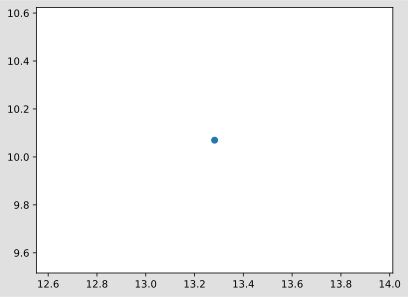

In [82]:
plt.plot(t_hill, t_hill2, '-o')
plt.show()

In [83]:
hill_climbing2(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])

{'Age': 4.7054795937440073e-08, 'VehicleYear': 1.098135369253998e-05, 'SocioEcon': 1.715668156199124e-05, 'MakeModel': 3.160452626734906e-05, 'RuggedAuto': 0.00025276634113081926, 'RiskAversion': 0.010524589528040872, 'DrivQuality': 0.17639730681674715}
{'Age': 4.7054795937440073e-08, 'VehicleYear': 1.098135369253998e-05, 'SocioEcon': 1.715668156199124e-05, 'MakeModel': 3.160452626734906e-05, 'RuggedAuto': 0.00025276634113081926, 'RiskAversion': 0.010524589528040872, 'DrivQuality': 0.17639730681674715}
['GoodStudent', 'Age']
{'VehicleYear': 1.098135369253998e-05, 'SocioEcon': 1.715668156199124e-05, 'MakeModel': 3.160452626734906e-05, 'RuggedAuto': 0.00025276634113081926, 'RiskAversion': 0.010524589528040872, 'DrivQuality': 0.17639730681674715}
['GoodStudent', 'Age', 'VehicleYear']
{'SocioEcon': 1.715668156199124e-05, 'MakeModel': 3.160452626734906e-05, 'RuggedAuto': 0.00025276634113081926, 'RiskAversion': 0.010524589528040872, 'DrivQuality': 0.17639730681674715}
['GoodStudent', 'Age', 

['GoodStudent',
 'Age',
 'VehicleYear',
 'SocioEcon',
 'MakeModel',
 'RuggedAuto',
 'RiskAversion',
 'DrivQuality']

In [85]:
import pygad

In [86]:
hyp_vars = ["Accident"]
prueba = X_test.head(1).to_numpy()
prueba[0][0:15] = np.nan
ev_vars = prepare_mapi(prueba, X_train.columns)[0]
supp_vars = [i for i in bn.names() if i not in ev_vars.keys() and i not in hyp_vars]
posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
y = posterior.argmax()[0][0]



def fitness_func(solution, solution_idx):
    set_R = []
    for i,rel in enumerate(solution) :
        if rel == 0 :
            set_R.append(supp_vars[i])
    irr, jsd = irrel, jsd = map_independence(bn, set_R = set_R, ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_posterior = posterior, return_jsd=True)
    if not irr :
        return -np.inf
    else :
        return len(set_R)+1-jsd

In [87]:
fitness_function = fitness_func

num_generations = 5
num_parents_mating = 3

sol_per_pop = 10
num_genes = len(supp_vars)

init_range_low = 0
init_range_high = 1.1

parent_selection_type = "sss"
keep_parents = 3

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

#Create initial population
rels,_,_ = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
rels = [i[0] for i in rels]
rel_index = [supp_vars.index(i) for i in rels]
initial_pop =[]
for i in range(0,sol_per_pop) :
    sol = [0]*len(supp_vars)
    for j in range(0,len(supp_vars)) :
        if j in rel_index :
            sol[j] = 1
        else :
            sol[j] = round(random.uniform(0,1))
    initial_pop.append(sol)

 of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::N

In [88]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population = initial_pop,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                        gene_type = int)

In [89]:
t0 = time.time()
ga_instance.run()
tf = time.time()
gen_time = tf-t0


In [90]:
t0 = time.time()
irrl = hill_climbing2(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
tf = time.time()
hill_time = tf-t0

leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gu

{'DrivQuality': 0.17821169923524158}
['VehicleYear', 'Antilock', 'SeniorTrain', 'RuggedAuto', 'Mileage', 'Theft', 'MakeModel', 'GoodStudent', 'Age', 'SocioEcon', 'RiskAversion', 'DrivQuality']


In [91]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [92]:
print("Genetic")
print(solution)
print([i for i in supp_vars if solution[supp_vars.index(i)] == 0])
print(gen_time)
print()
print("Hill climbing")
print(irrl)
print(hill_time)

Genetic
[0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]
['DrivQuality', 'SeniorTrain', 'VehicleYear', 'Antilock', 'SocioEcon', 'MakeModel', 'RiskAversion', 'DrivingSkill', 'Age', 'RuggedAuto', 'Theft', 'GoodStudent']
563.0604159832001

Hill climbing
['VehicleYear', 'Antilock', 'SeniorTrain', 'RuggedAuto', 'Mileage', 'Theft', 'MakeModel', 'GoodStudent', 'Age', 'SocioEcon', 'RiskAversion']
143.98380374908447


In [93]:
solution_fitness

12.754453813221993

In [94]:
supp_vars.index("Age")

11

In [95]:
supp_vars

['DrivQuality',
 'SeniorTrain',
 'VehicleYear',
 'ThisCarCost',
 'Antilock',
 'ThisCarDam',
 'SocioEcon',
 'Mileage',
 'MakeModel',
 'RiskAversion',
 'DrivingSkill',
 'Age',
 'RuggedAuto',
 'Theft',
 'GoodStudent']

In [304]:
med_data = pd.read_csv("hepatitis.csv")

print(med_data.dtypes)

# Impute continuous values
num_columns = ["age","bilirubin","alk_phosphate","sgot","albumin","protime"]
int_columns = ["age","alk_phosphate","sgot","protime"]
med_data_cont = med_data[num_columns]
imp = impute.IterativeImputer(missing_values=np.nan, initial_strategy = "mean")
med_data_cont = imp.fit_transform(med_data_cont)

# Add imputed contonuous values to dataset
med_data.drop(num_columns, axis = 1)
for i,name in enumerate(num_columns) :
    med_data[name] = med_data_cont.transpose()[i]

# Impute discrete values
imp = impute.SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
tmp = imp.fit_transform(med_data)
med_data = pd.DataFrame(tmp, columns=med_data.columns)

#Change types of imputed data
for i in  list_diff(num_columns,int_columns):
    med_data = med_data.astype({i: 'float64'})
for i in int_columns :
    med_data = med_data.astype({i: 'int64'})
        
# Binning. In quartiles, except for age and protime, which will be divide in uniform bins of length 10
for i in num_columns[1:5] :
    med_data[i], cut_bin = pd.qcut(med_data[i], q = 3, retbins = True)
med_data["age"], cut_bin = pd.cut(med_data["age"], bins = list(range(0,90,20)), retbins = True)
med_data["protime"], cut_bin = pd.cut(med_data["protime"], bins = list(range(0,110,25)), retbins = True, include_lowest = True)

# Convert from interval to object
for i in  num_columns:
    med_data = med_data.astype({i: 'str'})

med_data

age                  int64
sex                 object
steroid             object
antivirals            bool
fatigue             object
malaise             object
anorexia            object
liver_big           object
liver_firm          object
spleen_palpable     object
spiders             object
ascites             object
varices             object
bilirubin          float64
alk_phosphate      float64
sgot               float64
albumin            float64
protime            float64
histology             bool
class               object
dtype: object


age     sex steroid antivirals fatigue malaise anorexia liver_big  \
0    (20, 40]    male   False      False   False   False    False     False   
1    (40, 60]  female   False      False    True   False    False     False   
2    (60, 80]  female    True      False    True   False    False      True   
3    (20, 40]  female    True       True   False   False    False      True   
4    (20, 40]  female    True      False   False   False    False      True   
..        ...     ...     ...        ...     ...     ...      ...       ...   
150  (40, 60]  female    True      False    True    True     True      True   
151  (40, 60]  female    True      False    True   False    False      True   
152  (60, 80]  female   False      False    True    True    False     False   
153  (40, 60]    male   False      False    True   False    False      True   
154  (40, 60]  female    True      False    True   False    False      True   

    liver_firm spleen_palpable spiders ascites varices     bilirubin  \
0        False           False   False   False   False    (0.9, 1.3]   
1        False           False   False   False   False  (0.299, 0.9]   
2        False           False   False   False   False  (0.299, 0.9]   
3        False           False   False   False   False  (0.299, 0.9]   
4        False           False   False   False   False    (0.9, 1.3]   
..         ...             ...     ...     ...     ...           ...   
150      False           False    True    True    True    (1.3, 8.0]   
151       True           False   False   False   False  (0.299, 0.9]   
152       True           False    True   False   False  (0.299, 0.9]   
153      False            True    True   False    True    (1.3, 8.0]   
154      False            True    True    True   False    (0.9, 1.3]   

        alk_phosphate              sgot       albumin        protime  \
0      (25.999, 85.0]  (13.999, 43.333]    (3.7, 4.0]   (50.0, 75.0]   
1    (107.667, 295.0]  (13.999, 43.333]  (2.099, 3.7]   (50.0, 75.0]   
2     (85.0, 107.667]  (13.999, 43.333]    (3.7, 4.0]   (50.0, 75.0]   
3      (25.999, 85.0]    (43.333, 80.0]    (3.7, 4.0]  (75.0, 100.0]   
4    (107.667, 295.0]     (80.0, 648.0]    (3.7, 4.0]   (50.0, 75.0]   
..                ...               ...           ...            ...   
150  (107.667, 295.0]     (80.0, 648.0]  (2.099, 3.7]   (25.0, 50.0]   
151  (107.667, 295.0]     (80.0, 648.0]    (4.0, 6.4]   (50.0, 75.0]   
152    (25.999, 85.0]  (13.999, 43.333]    (4.0, 6.4]   (50.0, 75.0]   
153    (25.999, 85.0]  (13.999, 43.333]    (4.0, 6.4]   (25.0, 50.0]   
154   (85.0, 107.667]  (13.999, 43.333]  (2.099, 3.7]   (25.0, 50.0]   

    histology class  
0       False  live  
1       False  live  
2       False  live  
3       False  live  
4       False  live  
..        ...   ...  
150      True   die  
151      True  live  
152      True  live  
153      True  live  
154      True   die  

[155 rows x 20 columns]

In [305]:
med_data.isnull().sum()

age                0
sex                0
steroid            0
antivirals         0
fatigue            0
malaise            0
anorexia           0
liver_big          0
liver_firm         0
spleen_palpable    0
spiders            0
ascites            0
varices            0
bilirubin          0
alk_phosphate      0
sgot               0
albumin            0
protime            0
histology          0
class              0
dtype: int64

In [309]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = med_data[med_data.columns.drop("class")]
y = med_data["class"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

app = X_train.copy()
app["class"] = y_train

learner=gum.BNLearner(med_data)

bn_med = learner.learnBN()

bn_med=learner.useGreedyHillClimbing().useScoreK2().learnBN()

In [310]:
gnb.flow.add(gnb.getBN(bn_med,size="20"))
gnb.flow.display()

In [321]:
difficult = ["bilirubin","alk_phosphate","sgot","albumin","protime"]

irrelevancies = []
irrelevancies_heur = []

for i in X_test.head(3).to_numpy() :
    ev_vars = prepare_mapi([i], X_train.columns)[0]
    for i in difficult :
        ev_vars.pop(i)
    irrelevancies.append(check_every_r_silja(bn_med, ev_vars , ["class"]))
    irrelevancies_heur.append(hill_climbing(bn_med, ev_vars , ["class"]))

{'steroid', 'malaise', 'varices', 'alk_phosphate', 'sex', 'protime', 'anorexia', 'sgot', 'bilirubin', 'antivirals', 'liver_firm', 'fatigue', 'ascites', 'class', 'age', 'histology', 'spiders', 'albumin', 'spleen_palpable', 'liver_big'}
alk_phosphate
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
protime
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
sgot
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
bilirubin
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
albumin
['class']
['age'

{'class': 1}
Relevancies: 
[]
To eval: 
[('alk_phosphate',), ('protime',), ('sgot',), ('bilirubin',), ('albumin',)]
('die',)  ==  ('live',)
('die',)
{'class': 1}
('live',)  ==  ('live',)
['alk_phosphate', 'protime']
['alk_phosphate', 'sgot']
['alk_phosphate', 'bilirubin']
['alk_phosphate', 'albumin']
['protime', 'sgot']
['protime', 'bilirubin']
['protime', 'albumin']
['sgot', 'bilirubin']
['sgot', 'albumin']
['bilirubin', 'albumin']
['alk_phosphate', 'protime', 'sgot']
['alk_phosphate', 'protime', 'bilirubin']
['alk_phosphate', 'protime', 'albumin']
['alk_phosphate', 'sgot', 'bilirubin']
['alk_phosphate', 'sgot', 'albumin']
['alk_phosphate', 'bilirubin', 'albumin']
['protime', 'sgot', 'bilirubin']
['protime', 'sgot', 'albumin']
['protime', 'bilirubin', 'albumin']
['sgot', 'bilirubin', 'albumin']
['alk_phosphate', 'protime', 'sgot', 'bilirubin']
['alk_phosphate', 'protime', 'sgot', 'albumin']
['alk_phosphate', 'protime', 'bilirubin', 'albumin']
['alk_phosphate', 'sgot', 'bilirubin', 'al

['protime', 'sgot', 'albumin']
['protime', 'bilirubin', 'albumin']
['sgot', 'bilirubin', 'albumin']
['alk_phosphate', 'protime', 'sgot', 'bilirubin']
['alk_phosphate', 'protime', 'sgot', 'albumin']
['alk_phosphate', 'protime', 'bilirubin', 'albumin']
['alk_phosphate', 'sgot', 'bilirubin', 'albumin']
['protime', 'sgot', 'bilirubin', 'albumin']
['alk_phosphate', 'protime', 'sgot', 'bilirubin', 'albumin']
{'steroid', 'malaise', 'varices', 'alk_phosphate', 'sex', 'protime', 'anorexia', 'sgot', 'bilirubin', 'antivirals', 'liver_firm', 'fatigue', 'ascites', 'class', 'age', 'histology', 'spiders', 'albumin', 'spleen_palpable', 'liver_big'}
alk_phosphate
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
protime
['class']
['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices'

In [312]:
X_test.head(1).to_numpy()

array([['(60, 80]', 'female', False, False, True, True, False, True,
        False, False, False, False, False, '(0.9, 1.3]',
        '(85.0, 107.667]', '(43.333, 80.0]', '(2.099, 3.7]',
        '(50.0, 75.0]', False]], dtype=object)

In [323]:
i=2
print(irrelevancies[i][1][-1])
print(irrelevancies_heur[i])

('alk_phosphate', 'protime', 'sgot', 'bilirubin', 'albumin')
['alk_phosphate', 'protime', 'albumin', 'sgot', 'bilirubin']


In [318]:
bn_med.cpt("histology")

(pyAgrum.Potential<double>@0x4dc5ea0) 
             ||  histology        |
varice|ascite||False    |True     |
------|------||---------|---------|
False |False || 0.6535  | 0.3465  |
True  |False || 0.1667  | 0.8333  |
False |True  || 0.2143  | 0.7857  |
True  |True  || 0.1000  | 0.9000  |

In [238]:
irrelevant_set2

['sgot', 'alk_phosphate', 'albumin', 'histology', 'bilirubin', 'protime']

array([['(30, 40]', 'female', False, False, False, False, False, True,
        False, False, False, False, False, '(1.0, 1.5]',
        '(124.0, 295.0]', '(59.0, 99.0]', '(2.099, 3.5]', '(50.0, 60.0]',
        True],
       ['(30, 40]', 'female', True, False, False, False, False, True,
        False, False, False, False, False, '(0.8, 1.0]',
        '(25.999, 78.0]', '(59.0, 99.0]', '(4.2, 6.4]', '(50.0, 60.0]',
        False],
       ['(20, 30]', 'female', False, False, True, False, False, True,
        False, False, False, False, False, '(0.8, 1.0]', '(97.0, 124.0]',
        '(32.5, 59.0]', '(3.916, 4.2]', '(60.0, 70.0]', True],
       ['(70, 80]', 'female', True, True, True, False, False, True, True,
        False, False, False, False, '(0.8, 1.0]', '(97.0, 124.0]',
        '(32.5, 59.0]', '(2.099, 3.5]', '(40.0, 50.0]', True],
       ['(30, 40]', 'female', False, False, False, False, False, True,
        True, False, False, False, False, '(0.299, 0.8]',
        '(124.0, 295.0]', '(

In [247]:
X_test.to_numpy()

array([['(30, 40]', 'female', False, False, False, False, False, True,
        False, False, False, False, False, '(1.0, 1.5]',
        '(124.0, 295.0]', '(59.0, 99.0]', '(2.099, 3.5]', '(50.0, 60.0]',
        True],
       ['(30, 40]', 'female', True, False, False, False, False, True,
        False, False, False, False, False, '(0.8, 1.0]',
        '(25.999, 78.0]', '(59.0, 99.0]', '(4.2, 6.4]', '(50.0, 60.0]',
        False],
       ['(20, 30]', 'female', False, False, True, False, False, True,
        False, False, False, False, False, '(0.8, 1.0]', '(97.0, 124.0]',
        '(32.5, 59.0]', '(3.916, 4.2]', '(60.0, 70.0]', True],
       ['(70, 80]', 'female', True, True, True, False, False, True, True,
        False, False, False, False, '(0.8, 1.0]', '(97.0, 124.0]',
        '(32.5, 59.0]', '(2.099, 3.5]', '(40.0, 50.0]', True],
       ['(30, 40]', 'female', False, False, False, False, False, True,
        True, False, False, False, False, '(0.299, 0.8]',
        '(124.0, 295.0]', '(